In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de visualización
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Importar módulos de la arquitectura
from config.database import db_config
from utils.data_loader import DataLoader
from utils.preproccesor import DataPreprocessor
from utils.visualization import EducationalVisualizer
from utils.anomaly_detector import AnomalyDetector

print("✅ Módulos importados correctamente")

✅ Módulos importados correctamente


In [2]:
# Conectar a MongoDB
try:
    database = db_config.connect()
    print(f"✅ Conectado a la base de datos: {database.name}")
    
    # Obtener colecciones disponibles
    collections = database.list_collection_names()
    print(f"📚 Colecciones disponibles: {collections}")
    
except Exception as e:
    print(f"❌ Error conectando a la base de datos: {e}")
    # Crear datos de ejemplo para demostración
    print("🔄 Usando datos de ejemplo para demostración")

❌ Error conectando a MongoDB: 3.223.236.109:27017: timed out (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms), Timeout: 30s, Topology Description: <TopologyDescription id: 688d990da7007029aa503194, topology_type: Unknown, servers: [<ServerDescription ('3.223.236.109', 27017) server_type: Unknown, rtt: None, error=NetworkTimeout('3.223.236.109:27017: timed out (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms)')>]>
❌ Error conectando a la base de datos: 3.223.236.109:27017: timed out (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms), Timeout: 30s, Topology Description: <TopologyDescription id: 688d990da7007029aa503194, topology_type: Unknown, servers: [<ServerDescription ('3.223.236.109', 27017) server_type: Unknown, rtt: None, error=NetworkTimeout('3.223.236.109:27017: timed out (configured timeouts: socketTimeoutMS: 20000.0ms, connectTimeoutMS: 20000.0ms)')>]>
🔄 Usando datos de ejemplo para demostra

In [3]:
# Configurar fechas para el análisis
end_date = datetime.now()
start_date = end_date - timedelta(days=21)  # Últimos 21 días

print(f"📅 Período de análisis: {start_date.strftime('%Y-%m-%d')} a {end_date.strftime('%Y-%m-%d')}")

# Cargar datos de análisis de IA
try:
    ai_collection = db_config.get_collection('ai_analysis')
    ai_loader = DataLoader(ai_collection)
    ai_data = ai_loader.load_ai_analysis_data(start_date=start_date, end_date=end_date)
    print(f"🤖 Datos de análisis de IA cargados: {len(ai_data)} registros")
except Exception as e:
    print(f"⚠️ No se pudieron cargar datos de IA: {e}")
    ai_data = pd.DataFrame()

📅 Período de análisis: 2025-07-11 a 2025-08-01
⚠️ No se pudieron cargar datos de IA: Database objects do not implement truth value testing or bool(). Please compare with None instead: database is not None


In [4]:
# Cargar datos de citas
try:
    appointments_collection = db_config.get_collection('appointments')
    appointments_loader = DataLoader(appointments_collection)
    appointments_data = appointments_loader.load_appointments_data(start_date=start_date, end_date=end_date)
    print(f"�� Datos de citas cargados: {len(appointments_data)} registros")
except Exception as e:
    print(f"⚠️ No se pudieron cargar datos de citas: {e}")
    appointments_data = pd.DataFrame()

⚠️ No se pudieron cargar datos de citas: Database objects do not implement truth value testing or bool(). Please compare with None instead: database is not None


In [5]:
# Cargar datos de tareas (desde el checklist de citas)
try:
    tasks_data = appointments_loader.load_tasks_data(start_date=start_date, end_date=end_date)
    print(f"📋 Datos de tareas cargados: {len(tasks_data)} registros")
except Exception as e:
    print(f"⚠️ No se pudieron cargar datos de tareas: {e}")
    tasks_data = pd.DataFrame()

⚠️ No se pudieron cargar datos de tareas: name 'appointments_loader' is not defined


In [6]:
rng = np.random.default_rng(46)
limit = 10000

# Rango de fechas base (solo días)
start_date = datetime(2025, 1, 1)
end_date = datetime(2025, 7, 31)
days_range = (end_date - start_date).days + 1

# Generar fechas y horas aleatorias
created_at = []
for _ in range(limit):
    # Día aleatorio
    day_offset = rng.integers(0, days_range)
    base_date = start_date + timedelta(days=int(day_offset))
    # Hora, minuto, segundo aleatorio
    hour = rng.integers(0, 24)
    minute = rng.integers(0, 60)
    second = rng.integers(0, 60)
    microsecond = rng.integers(0, 1000) * 1000  # para milisegundos
    dt = base_date.replace(hour=hour, minute=minute, second=second, microsecond=microsecond)
    # Formato ISO 8601 con 'Z'
    created_at.append(dt.strftime('%Y-%m-%dT%H:%M:%S.%f')[:-3] + 'Z')

In [7]:
# Generar datos de ejemplo si no hay datos reales
if ai_data.empty or len(ai_data) <= 30:
    print("...Generando datos de ejemplo para análisis de IA...")

    def get_bullying_explanation(score):
        if score < 0.3:
            return 'Sin bullying detectado'
        elif score < 0.6:
            return 'Posible bullying detectado'
        else:
            return 'Bullying detectado'

    def get_concern_explanation(score):
        if score < 0.3:
            return 'Sin preocupaciones detectadas'
        elif score < 0.6:
            return 'Posible preocupación detectada'
        else:
            return 'Preocupación detectada'

    def get_academic_explanation(score):
        if score < 0.3:
            return 'Conversación poco constructiva'
        elif score < 0.6:
            return 'Conversación medianamente constructiva'
        else:
            return 'Conversación constructiva'

    bullying_scores = rng.uniform(0, 1, len(created_at))
    concern_scores = rng.uniform(0, 1, len(created_at))
    academic_scores = rng.uniform(0, 1, len(created_at))
    
    # Datos de análisis de IA con estructura correcta
    ai_data = pd.DataFrame({
        'created_at': created_at,
        'sender_id': [f'student_{i}' for i in rng.integers(1, 21, size=len(created_at))],
        'recipient_id': [f'tutor_{i}' for i in rng.integers(1, 6, size=len(created_at))],
        'message_content': [f'Mensaje de ejemplo {i}' for i in range(len(created_at))],
        'analysis': [
            {
                'bullying': score,
                'concern': c_score,
                'academic_constructive': a_score,
                'bullying_explanation': get_bullying_explanation(score),
                'concern_explanation': get_concern_explanation(c_score),
                'academic_explanation': get_academic_explanation(a_score)
            }
            for score, c_score, a_score in zip(bullying_scores, concern_scores, academic_scores)
        ]
    })

    ai_data['message_length'] = ai_data['message_content'].str.len()
    
    print(f"✅ Datos de ejemplo generados: {len(ai_data)} registros")

if appointments_data.empty or len(appointments_data) <= 30:
    print("...Generando datos de ejemplo para citas...")
    appointment_dates = created_at
    
    appointments_data = pd.DataFrame({
        'fecha_cita': appointment_dates,
        'id_tutor': [f'tutor_{i}' for i in rng.integers(1, 6, len(appointment_dates))],
        'id_alumno': [f'student_{i}' for i in rng.integers(1, 21, len(appointment_dates))],
        'estado_cita': rng.choice(['pendiente', 'confirmada', 'completada', 'cancelada', 'no_asistio'], len(appointment_dates), p=[0.2, 0.3, 0.3, 0.1, 0.1]),
        'reason': ['Consulta académica'] * len(appointment_dates),
        'checklist': [[{'description': f'Tarea {i}', 'completed': rng.choice([True, False])} for i in range(rng.integers(1, 4))] for _ in range(len(appointment_dates))],
        'created_at': created_at,
        'updated_at': created_at,
    })
    
    print(f"✅ Datos de citas generados: {len(appointments_data)} registros")

if tasks_data.empty or len(tasks_data) <= 30:
    print("...Generando datos de ejemplo para tareas...")
    
    # Extraer tareas del checklist de citas
    tasks_list = []
    for _, appointment in appointments_data.iterrows():
        for task in appointment['checklist']:
            tasks_list.append({
                'appointment_id': f'appointment_{len(tasks_list)}',
                'id_tutor': appointment['id_tutor'],
                'id_alumno': appointment['id_alumno'],
                'fecha_cita': appointment['fecha_cita'],
                'estado_cita': appointment['estado_cita'],
                'task_description': task['description'],
                'task_completed': task['completed']
            })
    
    tasks_data = pd.DataFrame(tasks_list)
    print(f"✅ Datos de tareas generados: {len(tasks_data)} registros")

...Generando datos de ejemplo para análisis de IA...
✅ Datos de ejemplo generados: 10000 registros
...Generando datos de ejemplo para citas...
✅ Datos de citas generados: 10000 registros
...Generando datos de ejemplo para tareas...
✅ Datos de tareas generados: 20024 registros


In [8]:
# Información general de los datasets
print("📊 RESUMEN DE DATOS")
print("=" * 50)

print(f"\nANÁLISIS DE IA:")
print(f"   - Registros: {len(ai_data)}")
if not ai_data.empty:
    print(f"   - Columnas: {list(ai_data.columns)}")
    print(f"   - Período: {ai_data['created_at'].min()} a {ai_data['created_at'].max()}")
    print(f"   - Estudiantes únicos: {ai_data['sender_id'].nunique()}")
    print(f"   - Tutores únicos: {ai_data['recipient_id'].nunique()}")

print(f"\nCITAS:")
print(f"   - Registros: {len(appointments_data)}")
if not appointments_data.empty:
    print(f"   - Columnas: {list(appointments_data.columns)}")
    print(f"   - Período: {appointments_data['fecha_cita'].min()} a {appointments_data['fecha_cita'].max()}")
    print(f"   - Estados: {appointments_data['estado_cita'].value_counts().to_dict()}")

print(f"\nTAREAS:")
print(f"   - Registros: {len(tasks_data)}")
if not tasks_data.empty:
    print(f"   - Columnas: {list(tasks_data.columns)}")
    print(f"   - Tasa de completado: {tasks_data['task_completed'].mean():.2%}")
    print(f"   - Tareas por cita: {len(tasks_data) / len(appointments_data):.1f}")

📊 RESUMEN DE DATOS

ANÁLISIS DE IA:
   - Registros: 10000
   - Columnas: ['created_at', 'sender_id', 'recipient_id', 'message_content', 'analysis', 'message_length']
   - Período: 2025-01-01T00:38:43.478Z a 2025-07-31T23:46:18.105Z
   - Estudiantes únicos: 20
   - Tutores únicos: 5

CITAS:
   - Registros: 10000
   - Columnas: ['fecha_cita', 'id_tutor', 'id_alumno', 'estado_cita', 'reason', 'checklist', 'created_at', 'updated_at']
   - Período: 2025-01-01T00:38:43.478Z a 2025-07-31T23:46:18.105Z
   - Estados: {'confirmada': 3002, 'completada': 2975, 'pendiente': 1999, 'cancelada': 1016, 'no_asistio': 1008}

TAREAS:
   - Registros: 20024
   - Columnas: ['appointment_id', 'id_tutor', 'id_alumno', 'fecha_cita', 'estado_cita', 'task_description', 'task_completed']
   - Tasa de completado: 49.70%
   - Tareas por cita: 2.0


In [9]:
anomaly_detector = AnomalyDetector()

print("🔍 DETECCIÓN DE ANOMALÍAS - VALIDACIÓN INICIAL")
print("=" * 60)

# 1. ANÁLISIS DE DATOS DE IA
print("\n🤖 ANÁLISIS DE DATOS DE IA:")
print("-" * 40)

ai_anomalies = anomaly_detector.detect_preprocessing_anomalies_chunked(ai_data, 'ai_data', chunk_size=1000)

print(f"📊 Score de calidad: {ai_anomalies['summary']['data_quality_score']:.1f}/100")
print(f"📈 Registros totales: {ai_anomalies['summary']['total_records']}")

# Mostrar anomalías específicas de IA
if 'domain_specific' in ai_anomalies:
    domain = ai_anomalies['domain_specific']
    
    if 'invalid_scores' in domain:
        invalid = domain['invalid_scores']
        print(f"⚠️  Scores fuera de rango:")
        print(f"   - Bullying: {invalid['bullying_out_of_range']}")
        print(f"   - Concern: {invalid['concern_out_of_range']}")
        print(f"   - Academic: {invalid['academic_out_of_range']}")
    
    if 'suspicious_patterns' in domain:
        print(f"🚨 Patrones sospechosos: {domain['suspicious_patterns']['identical_scores']} scores idénticos")
    
    if 'constant_scores' in domain:
        constant = domain['constant_scores']
        if any(constant.values()):
            print("⚠️  Scores constantes detectados (posible error en modelo de IA)")

# Mostrar anomalías avanzadas
if 'advanced_anomalies' in ai_anomalies:
    advanced = ai_anomalies['advanced_anomalies']
    if 'isolation_forest' in advanced and 'anomaly_percentage' in advanced['isolation_forest']:
        print(f"🔍 Anomalías (Isolation Forest): {advanced['isolation_forest']['anomaly_percentage']:.1f}%")
    if 'local_outlier_factor' in advanced and 'anomaly_percentage' in advanced['local_outlier_factor']:
        print(f"🔍 Anomalías (LOF): {advanced['local_outlier_factor']['anomaly_percentage']:.1f}%")

🔍 DETECCIÓN DE ANOMALÍAS - VALIDACIÓN INICIAL

🤖 ANÁLISIS DE DATOS DE IA:
----------------------------------------
🔄 Procesando dataset de 10000 registros en chunks de 1000...
   Procesando chunk 1/10 (registros 1-1000)
   Procesando chunk 2/10 (registros 1001-2000)
   Procesando chunk 3/10 (registros 2001-3000)
   Procesando chunk 4/10 (registros 3001-4000)
   Procesando chunk 5/10 (registros 4001-5000)
   Procesando chunk 6/10 (registros 5001-6000)
   Procesando chunk 7/10 (registros 6001-7000)
   Procesando chunk 8/10 (registros 7001-8000)
   Procesando chunk 9/10 (registros 8001-9000)
   Procesando chunk 10/10 (registros 9001-10000)
📊 Score de calidad: 100.0/100
📈 Registros totales: 10000
⚠️  Scores fuera de rango:
   - Bullying: 0
   - Concern: 0
   - Academic: 0


In [10]:
# 2. ANÁLISIS DE DATOS DE CITAS
print("\n📅 ANÁLISIS DE DATOS DE CITAS:")
print("-" * 40)

appointments_anomalies = anomaly_detector.detect_preprocessing_anomalies_chunked(appointments_data, 'appointments_data', chunk_size=1000)

print(f"📊 Score de calidad: {appointments_anomalies['summary']['data_quality_score']:.1f}/100")
print(f"📈 Registros totales: {appointments_anomalies['summary']['total_records']}")

# Mostrar anomalías específicas de citas
if 'domain_specific' in appointments_anomalies:
    domain = appointments_anomalies['domain_specific']
    
    if 'invalid_appointment_states' in domain:
        invalid_states = domain['invalid_appointment_states']
        if invalid_states['count'] > 0:
            print(f"⚠️  Estados de cita inválidos: {invalid_states['count']}")
            print(f"   - Valores: {invalid_states['invalid_values']}")
    
    if 'date_anomalies' in domain:
        dates = domain['date_anomalies']
        print(f"📅 Anomalías de fechas:")
        print(f"   - Futuro lejano: {dates['far_future_appointments']}")
        print(f"   - Pasado lejano: {dates['far_past_appointments']}")
    
    if 'checklist_structure' in domain:
        checklist = domain['checklist_structure']
        print(f"📋 Problemas en checklists:")
        print(f"   - Malformados: {checklist['malformed_checklists']}")
        print(f"   - Vacíos: {checklist['empty_checklists']}")


📅 ANÁLISIS DE DATOS DE CITAS:
----------------------------------------
🔄 Procesando dataset de 10000 registros en chunks de 1000...
   Procesando chunk 1/10 (registros 1-1000)
   Procesando chunk 2/10 (registros 1001-2000)
   Procesando chunk 3/10 (registros 2001-3000)
   Procesando chunk 4/10 (registros 3001-4000)
   Procesando chunk 5/10 (registros 4001-5000)
   Procesando chunk 6/10 (registros 5001-6000)
   Procesando chunk 7/10 (registros 6001-7000)
   Procesando chunk 8/10 (registros 7001-8000)
   Procesando chunk 9/10 (registros 8001-9000)
   Procesando chunk 10/10 (registros 9001-10000)
📊 Score de calidad: 100.0/100
📈 Registros totales: 10000


In [11]:
# 3. ANÁLISIS DE DATOS DE TAREAS
print("\n✅ ANÁLISIS DE DATOS DE TAREAS:")
print("-" * 40)

tasks_anomalies = anomaly_detector.detect_preprocessing_anomalies_chunked(tasks_data, 'tasks_data', chunk_size=1000)

print(f"📊 Score de calidad: {tasks_anomalies['summary']['data_quality_score']:.1f}/100")
print(f"📈 Registros totales: {tasks_anomalies['summary']['total_records']}")

# Mostrar anomalías específicas de tareas
if 'domain_specific' in tasks_anomalies:
    domain = tasks_anomalies['domain_specific']
    
    if 'empty_task_descriptions' in domain:
        empty = domain['empty_task_descriptions']
        print(f"⚠️  Tareas sin descripción: {empty['count']} ({empty['percentage']:.1f}%)")
    
    if 'completed_tasks_cancelled_appointments' in domain:
        cancelled = domain['completed_tasks_cancelled_appointments']
        print(f"🚨 Tareas completadas en citas canceladas: {cancelled['count']}")

# RESUMEN GENERAL
print("\n📋 RESUMEN DE CALIDAD DE DATOS:")
print("=" * 60)

datasets = {
    'IA': ai_anomalies,
    'Citas': appointments_anomalies,
    'Tareas': tasks_anomalies
}

for name, anomalies in datasets.items():
    score = anomalies['summary']['data_quality_score']
    missing = anomalies['missing_values']['total_percentage']
    duplicates = anomalies['duplicates']['percentage']
    
    print(f"\n{name}:")
    print(f"   - Score: {score:.1f}/100")
    print(f"   - Valores faltantes: {missing:.1f}%")
    print(f"   - Duplicados: {duplicates:.1f}%")
    
    # Clasificar calidad
    if score >= 90:
        status = "🟢 Excelente"
    elif score >= 75:
        status = "🟡 Buena"
    elif score >= 60:
        status = "🟠 Aceptable"
    else:
        status = "🔴 Requiere atención"
    
    print(f"   - Estado: {status}")

# RECOMENDACIONES
print("\n💡 RECOMENDACIONES:")
print("-" * 40)

# Identificar datasets con problemas
problematic_datasets = []
for name, anomalies in datasets.items():
    score = anomalies['summary']['data_quality_score']
    if score < 75:
        problematic_datasets.append(name)

if problematic_datasets:
    print(f"⚠️  Datasets que requieren atención: {', '.join(problematic_datasets)}")
    print("   - Revisar valores faltantes")
    print("   - Validar duplicados")
    print("   - Verificar anomalías específicas del dominio")
else:
    print("✅ Todos los datasets tienen buena calidad de datos")
    print("   - Se puede proceder con el preprocesamiento")

anomalies_summary_before_preprocessing = {
    'ai_anomalies': ai_anomalies,
    'appointments_anomalies': appointments_anomalies,
    'tasks_anomalies': tasks_anomalies,
    'overall_quality': {name: anomalies['summary']['data_quality_score'] 
                       for name, anomalies in datasets.items()}
}


✅ ANÁLISIS DE DATOS DE TAREAS:
----------------------------------------
🔄 Procesando dataset de 20024 registros en chunks de 1000...
   Procesando chunk 1/21 (registros 1-1000)
   Procesando chunk 2/21 (registros 1001-2000)
   Procesando chunk 3/21 (registros 2001-3000)
   Procesando chunk 4/21 (registros 3001-4000)
   Procesando chunk 5/21 (registros 4001-5000)
   Procesando chunk 6/21 (registros 5001-6000)
   Procesando chunk 7/21 (registros 6001-7000)
   Procesando chunk 8/21 (registros 7001-8000)
   Procesando chunk 9/21 (registros 8001-9000)
   Procesando chunk 10/21 (registros 9001-10000)
   Procesando chunk 11/21 (registros 10001-11000)
   Procesando chunk 12/21 (registros 11001-12000)
   Procesando chunk 13/21 (registros 12001-13000)
   Procesando chunk 14/21 (registros 13001-14000)
   Procesando chunk 15/21 (registros 14001-15000)
   Procesando chunk 16/21 (registros 15001-16000)
   Procesando chunk 17/21 (registros 16001-17000)
   Procesando chunk 18/21 (registros 17001-1800

In [12]:
# CÓDIGO DE DIAGNÓSTICO CORREGIDO PARA NOTEBOOK
# Ejecutar en una celda separada antes del bloque problemático

def diagnosticar_datos_ai():
    """Diagnóstico completo de datos de IA"""
    print("�� DIAGNÓSTICO DE DATOS DE IA")
    print("=" * 50)
    
    # 1. Verificar estructura básica
    print(f"1. Estructura básica:")
    print(f"   - DataFrame vacío: {ai_data.empty}")
    print(f"   - Tamaño: {ai_data.shape}")
    print(f"   - Columnas: {list(ai_data.columns)}")
    
    # 2. Verificar columna 'analysis'
    if 'analysis' in ai_data.columns:
        print(f"\n2. Columna 'analysis' encontrada:")
        print(f"   - Tipo de datos: {ai_data['analysis'].dtype}")
        
        # Verificar estructura del primer elemento
        first_analysis = ai_data['analysis'].iloc[0]
        print(f"   - Primer elemento: {type(first_analysis)}")
        
        if isinstance(first_analysis, dict):
            print(f"   - Claves disponibles: {list(first_analysis.keys())}")
            print(f"   - Valores de ejemplo: {first_analysis}")
            
            # Verificar si todos los elementos son diccionarios
            dict_count = sum(1 for x in ai_data['analysis'] if isinstance(x, dict))
            print(f"   - Elementos tipo dict: {dict_count}/{len(ai_data)}")
            
            # Verificar claves consistentes
            if dict_count > 0:
                sample_keys = set()
                for i in range(min(5, len(ai_data))):  # Revisar primeros 5 elementos
                    if isinstance(ai_data['analysis'].iloc[i], dict):
                        sample_keys.update(ai_data['analysis'].iloc[i].keys())
                print(f"   - Claves encontradas en muestra: {list(sample_keys)}")
        else:
            print(f"   - Valor: {first_analysis}")
    else:
        print(f"\n2. ❌ Columna 'analysis' NO encontrada")
    
    # 3. Verificar columna 'created_at'
    if 'created_at' in ai_data.columns:
        print(f"\n3. Columna 'created_at' encontrada:")
        print(f"   - Tipo: {ai_data['created_at'].dtype}")
        try:
            print(f"   - Rango: {ai_data['created_at'].min()} a {ai_data['created_at'].max()}")
        except:
            print(f"   - No se puede calcular rango (posiblemente no es datetime)")
    else:
        print(f"\n3. ❌ Columna 'created_at' NO encontrada")
    
    # 4. Verificar columna 'message_length'
    if 'message_length' in ai_data.columns:
        print(f"\n4. Columna 'message_length' encontrada:")
        print(f"   - Tipo: {ai_data['message_length'].dtype}")
        print(f"   - Estadísticas: {ai_data['message_length'].describe()}")
    else:
        print(f"\n4. ❌ Columna 'message_length' NO encontrada")
    
    # 5. Verificar columna 'message_content'
    if 'message_content' in ai_data.columns:
        print(f"\n5. Columna 'message_content' encontrada:")
        print(f"   - Tipo: {ai_data['message_content'].dtype}")
        print(f"   - Longitud promedio: {ai_data['message_content'].str.len().mean():.1f} caracteres")
    else:
        print(f"\n5. ❌ Columna 'message_content' NO encontrada")
    
    return True

def diagnosticar_preprocesamiento():
    """Diagnóstico del preprocesamiento"""
    print("\n�� DIAGNÓSTICO DE PREPROCESAMIENTO")
    print("=" * 50)
    
    # Convertir fechas
    if 'created_at' in ai_data.columns:
        ai_data['created_at'] = pd.to_datetime(ai_data['created_at'])
    
    # Aplicar preprocesamiento
    preprocessor = DataPreprocessor()
    ai_clean = preprocessor.clean_ai_analysis_data(ai_data)
    
    print(f"\n1. Después del preprocesamiento:")
    print(f"   - Columnas resultantes: {list(ai_clean.columns)}")
    
    # Verificar columnas específicas
    required_columns = ['bullying', 'concern', 'academic_constructive', 'message_length']
    for col in required_columns:
        if col in ai_clean.columns:
            non_null = ai_clean[col].notna().sum()
            print(f"   - {col}: {non_null}/{len(ai_clean)} valores no nulos")
            if non_null > 0:
                print(f"     Rango: {ai_clean[col].min():.3f} a {ai_clean[col].max():.3f}")
        else:
            print(f"   - ❌ {col}: NO encontrada")
    
    return ai_clean

def diagnosticar_agregacion(ai_clean):
    """Diagnóstico de la agregación"""
    print("\n📊 DIAGNÓSTICO DE AGREGACIÓN")
    print("=" * 50)
    
    # Crear features temporales
    preprocessor = DataPreprocessor()
    ai_features = preprocessor.create_time_series_features(ai_clean, 'created_at')
    
    print(f"1. Después de features temporales:")
    print(f"   - Columnas: {list(ai_features.columns)}")
    
    # Intentar agregación con columnas disponibles
    available_columns = ['bullying', 'concern', 'academic_constructive', 'message_length']
    existing_columns = [col for col in available_columns if col in ai_features.columns]
    
    if existing_columns:
        print(f"\n2. Columnas disponibles para agregación: {existing_columns}")
        
        # Crear funciones de agregación solo para columnas existentes
        agg_functions = {}
        for col in existing_columns:
            if col == 'message_length':
                agg_functions[col] = ['mean', 'std', 'count']
            else:
                agg_functions[col] = ['sum', 'mean', 'std']
        
        print(f"3. Funciones de agregación: {agg_functions}")
        
        # Intentar agregación
        try:
            ai_aggregated = preprocessor.aggregate_by_time_period(
                ai_features,
                date_column='created_at',
                period='D',
                agg_functions=agg_functions
            )
            print(f"4. ✅ Agregación exitosa: {len(ai_aggregated)} períodos")
            return ai_aggregated
        except Exception as e:
            print(f"4. ❌ Error en agregación: {str(e)}")
            return None
    else:
        print("2. ❌ No hay columnas disponibles para agregación")
        return None

def crear_columnas_por_defecto():
    """Crear columnas faltantes con valores por defecto"""
    print("\n🔧 CREANDO COLUMNAS POR DEFECTO")
    print("=" * 50)
    
    ai_data_fixed = ai_data.copy()
    
    # Crear columnas si no existen
    if 'bullying' not in ai_data_fixed.columns:
        ai_data_fixed['bullying'] = 0.0
        print("   - Creada columna 'bullying' con valor 0.0")
    
    if 'concern' not in ai_data_fixed.columns:
        ai_data_fixed['concern'] = 0.0
        print("   - Creada columna 'concern' con valor 0.0")
    
    if 'academic_constructive' not in ai_data_fixed.columns:
        ai_data_fixed['academic_constructive'] = 0.0
        print("   - Creada columna 'academic_constructive' con valor 0.0")
    
    if 'message_length' not in ai_data_fixed.columns:
        if 'message_content' in ai_data_fixed.columns:
            ai_data_fixed['message_length'] = ai_data_fixed['message_content'].str.len()
            print("   - Creada columna 'message_length' basada en 'message_content'")
        else:
            ai_data_fixed['message_length'] = 0
            print("   - Creada columna 'message_length' con valor 0")
    
    return ai_data_fixed

def extraer_datos_analysis():
    """Extraer datos de la columna analysis si existe"""
    print("\n📋 EXTRAYENDO DATOS DE COLUMNA 'analysis'")
    print("=" * 50)
    
    if 'analysis' not in ai_data.columns:
        print("❌ Columna 'analysis' no encontrada")
        return ai_data
    
    ai_data_extracted = ai_data.copy()
    
    # Extraer valores de analysis
    try:
        ai_data_extracted['bullying'] = ai_data_extracted['analysis'].apply(
            lambda x: x.get('bullying', 0.0) if isinstance(x, dict) else 0.0
        )
        ai_data_extracted['concern'] = ai_data_extracted['analysis'].apply(
            lambda x: x.get('concern', 0.0) if isinstance(x, dict) else 0.0
        )
        ai_data_extracted['academic_constructive'] = ai_data_extracted['analysis'].apply(
            lambda x: x.get('academic_constructive', 0.0) if isinstance(x, dict) else 0.0
        )
        
        print("✅ Datos extraídos de columna 'analysis':")
        print(f"   - bullying: {ai_data_extracted['bullying'].notna().sum()} valores")
        print(f"   - concern: {ai_data_extracted['concern'].notna().sum()} valores")
        print(f"   - academic_constructive: {ai_data_extracted['academic_constructive'].notna().sum()} valores")
        
    except Exception as e:
        print(f"❌ Error extrayendo datos: {str(e)}")
    
    return ai_data_extracted

# EJECUTAR DIAGNÓSTICO COMPLETO
print("�� INICIANDO DIAGNÓSTICO COMPLETO")
print("=" * 60)

# Paso 1: Diagnosticar datos originales
diagnosticar_datos_ai()

# Paso 2: Extraer datos de analysis si es necesario
ai_data_processed = extraer_datos_analysis()

# Paso 3: Diagnosticar preprocesamiento
ai_clean = diagnosticar_preprocesamiento()

# Paso 4: Diagnosticar agregación
if not ai_clean.empty:
    ai_aggregated = diagnosticar_agregacion(ai_clean)
    
    if ai_aggregated is not None:
        print(f"\n✅ DIAGNÓSTICO COMPLETADO EXITOSAMENTE")
        print(f"   - Datos agregados: {len(ai_aggregated)} períodos")
        print(f"   - Columnas finales: {list(ai_aggregated.columns)}")
    else:
        print(f"\n⚠️  PROBLEMA EN AGREGACIÓN - Creando columnas por defecto")
        ai_data_fixed = crear_columnas_por_defecto()
        print(f"   - Datos corregidos listos para usar")
else:
    print(f"\n❌ PROBLEMA EN PREPROCESAMIENTO")

�� INICIANDO DIAGNÓSTICO COMPLETO
�� DIAGNÓSTICO DE DATOS DE IA
1. Estructura básica:
   - DataFrame vacío: False
   - Tamaño: (10000, 6)
   - Columnas: ['created_at', 'sender_id', 'recipient_id', 'message_content', 'analysis', 'message_length']

2. Columna 'analysis' encontrada:
   - Tipo de datos: object
   - Primer elemento: <class 'dict'>
   - Claves disponibles: ['bullying', 'concern', 'academic_constructive', 'bullying_explanation', 'concern_explanation', 'academic_explanation']
   - Valores de ejemplo: {'bullying': np.float64(0.8408506850912019), 'concern': np.float64(0.5518608017078745), 'academic_constructive': np.float64(0.5790763979142823), 'bullying_explanation': 'Bullying detectado', 'concern_explanation': 'Posible preocupación detectada', 'academic_explanation': 'Conversación medianamente constructiva'}
   - Elementos tipo dict: 10000/10000
   - Claves encontradas en muestra: ['concern_explanation', 'bullying_explanation', 'concern', 'bullying', 'academic_explanation', 'a

In [13]:
appointments_data['fecha_cita'] = pd.to_datetime(appointments_data['fecha_cita'])
appointments_data['created_at'] = pd.to_datetime(appointments_data['created_at'])

preprocessor = DataPreprocessor()

# Limpiar datos de análisis de IA
if not ai_data.empty:
    print("...Limpiando datos de análisis de IA...")
    ai_data['created_at'] = pd.to_datetime(ai_data['created_at'])
    ai_clean = preprocessor.clean_ai_analysis_data(ai_data)
    
    # Crear features temporales
    ai_features = preprocessor.create_time_series_features(ai_clean, 'created_at')
    
    # AGREGACIÓN TEMPORAL (SOLUCIÓN CORREGIDA)
    print("...Agregando datos de IA por período...")
    
    # Verificar columnas disponibles antes de agregar
    available_columns = ['bullying', 'concern', 'academic_constructive', 'message_length']
    existing_columns = [col for col in available_columns if col in ai_features.columns]
    
    if existing_columns:
        print(f"   - Columnas a agregar: {existing_columns}")
        
        # SOLUCIÓN ALTERNATIVA: Agregación manual
        try:
            # Intentar agregación con el preprocessor
            agg_functions = {}
            for col in existing_columns:
                if col == 'message_length':
                    agg_functions[col] = ['mean', 'std', 'count']
                else:
                    agg_functions[col] = ['sum', 'mean', 'std']
            
            ai_aggregated = preprocessor.aggregate_by_time_period(
                ai_features, 
                date_column='created_at',
                period='D',
                agg_functions=agg_functions
            )
            print(f"   - Datos agregados: {len(ai_aggregated)} días")
            
        except Exception as e:
            print(f"   ⚠️  Error en agregación automática: {str(e)}")
            print("   🔧 Aplicando agregación manual...")
            
            # Agregación manual como fallback
            ai_aggregated = ai_features.set_index('created_at').resample('D').agg({
                'bullying': ['sum', 'mean', 'std'],
                'concern': ['sum', 'mean', 'std'],
                'academic_constructive': ['sum', 'mean', 'std'],
                'message_length': ['mean', 'std', 'count']
            })
            
            # Aplanar nombres de columnas
            ai_aggregated.columns = [f'{col[0]}_{col[1]}' for col in ai_aggregated.columns]
            print(f"   - Datos agregados manualmente: {len(ai_aggregated)} días")
    else:
        print("   ⚠️  No hay columnas disponibles para agregación")
        ai_aggregated = pd.DataFrame()
    
    # MANEJO DE VALORES FALTANTES (SOLUCIÓN CORREGIDA)
    if not ai_aggregated.empty:
        print("...Manejando valores faltantes...")
        
        # Verificar si tiene DatetimeIndex para interpolación temporal
        if isinstance(ai_aggregated.index, pd.DatetimeIndex):
            ai_aggregated_clean = preprocessor.handle_missing_values(ai_aggregated, strategy='interpolate')
        else:
            # Si no tiene DatetimeIndex, usar forward fill
            print("   ⚠️  No hay DatetimeIndex, usando forward fill")
            ai_aggregated_clean = preprocessor.handle_missing_values(ai_aggregated, strategy='forward')
        
        # NORMALIZACIÓN
        print("...Normalizando features...")
        ai_normalized = preprocessor.normalize_features(ai_aggregated_clean)
    else:
        ai_aggregated_clean = pd.DataFrame()
        ai_normalized = pd.DataFrame()
    
    print(f"   - Registros originales: {len(ai_data)}")
    print(f"   - Registros limpios: {len(ai_clean)}")
    print(f"   - Días agregados: {len(ai_aggregated)}")
    if not ai_normalized.empty:
        print(f"   - Features normalizados: {list(ai_normalized.columns)}")
else:
    ai_clean = pd.DataFrame()
    ai_features = pd.DataFrame()
    ai_aggregated = pd.DataFrame()
    ai_normalized = pd.DataFrame()

# Limpiar datos de citas
if not appointments_data.empty:
    print("\n...Limpiando datos de citas...")
    appointments_clean = preprocessor.clean_appointments_data(appointments_data)
    
    # Crear features temporales para citas
    appointments_features = preprocessor.create_time_series_features(appointments_clean, 'fecha_cita')
    
    # AGREGACIÓN TEMPORAL para citas (SOLUCIÓN CORREGIDA)
    print("...Agregando datos de citas por período...")
    
    # Verificar columnas disponibles
    available_appointment_columns = ['status_code', 'days_to_appointment']
    existing_appointment_columns = [col for col in available_appointment_columns if col in appointments_features.columns]
    
    if existing_appointment_columns:
        print(f"   - Columnas a agregar: {existing_appointment_columns}")
        
        try:
            agg_appointment_functions = {}
            for col in existing_appointment_columns:
                if col == 'status_code':
                    agg_appointment_functions[col] = ['mean', 'count']
                else:
                    agg_appointment_functions[col] = ['mean', 'std']
            
            appointments_aggregated = preprocessor.aggregate_by_time_period(
                appointments_features,
                date_column='fecha_cita',
                period='D',
                agg_functions=agg_appointment_functions
            )
        except Exception as e:
            print(f"   ⚠️  Error en agregación automática: {str(e)}")
            print("   🔧 Aplicando agregación manual...")
            
            # Agregación manual
            appointments_aggregated = appointments_features.set_index('fecha_cita').resample('D').agg({
                'status_code': ['mean', 'count'],
                'days_to_appointment': ['mean', 'std']
            })
            appointments_aggregated.columns = [f'{col[0]}_{col[1]}' for col in appointments_aggregated.columns]
        
        # MANEJO DE VALORES FALTANTES
        if isinstance(appointments_aggregated.index, pd.DatetimeIndex):
            appointments_aggregated_clean = preprocessor.handle_missing_values(appointments_aggregated, strategy='forward')
        else:
            appointments_aggregated_clean = appointments_aggregated.fillna(method='ffill')
    else:
        print("   ⚠️  No hay columnas disponibles para agregación")
        appointments_aggregated = pd.DataFrame()
        appointments_aggregated_clean = pd.DataFrame()
    
    print(f"   - Registros originales: {len(appointments_data)}")
    print(f"   - Registros limpios: {len(appointments_clean)}")
    print(f"   - Días agregados: {len(appointments_aggregated)}")
else:
    appointments_clean = pd.DataFrame()
    appointments_aggregated = pd.DataFrame()

# Limpiar datos de tareas
if not tasks_data.empty:
    print("\n...Limpiando datos de tareas...")
    tasks_clean = preprocessor.clean_tasks_data(tasks_data)
    
    # Crear features temporales para tareas
    tasks_features = preprocessor.create_time_series_features(tasks_clean, 'fecha_cita')
    
    # AGREGACIÓN TEMPORAL para tareas (SOLUCIÓN CORREGIDA)
    print("...Agregando datos de tareas por período...")
    
    # Verificar columnas disponibles
    available_task_columns = ['task_completed', 'task_length', 'time_to_complete_hours']
    existing_task_columns = [col for col in available_task_columns if col in tasks_features.columns]
    
    if existing_task_columns:
        print(f"   - Columnas a agregar: {existing_task_columns}")
        
        try:
            agg_task_functions = {}
            for col in existing_task_columns:
                if col == 'task_completed':
                    agg_task_functions[col] = ['sum', 'mean']
                else:
                    agg_task_functions[col] = ['mean', 'std']
            
            tasks_aggregated = preprocessor.aggregate_by_time_period(
                tasks_features,
                date_column='fecha_cita',
                period='D',
                agg_functions=agg_task_functions
            )
        except Exception as e:
            print(f"   ⚠️  Error en agregación automática: {str(e)}")
            print("   🔧 Aplicando agregación manual...")
            
            # Agregación manual
            tasks_aggregated = tasks_features.set_index('fecha_cita').resample('D').agg({
                'task_completed': ['sum', 'mean'],
                'task_length': ['mean', 'std'],
                'time_to_complete_hours': ['mean', 'std']
            })
            tasks_aggregated.columns = [f'{col[0]}_{col[1]}' for col in tasks_aggregated.columns]
        
        # MANEJO DE VALORES FALTANTES
        if isinstance(tasks_aggregated.index, pd.DatetimeIndex):
            tasks_aggregated_clean = preprocessor.handle_missing_values(tasks_aggregated, strategy='zero')
        else:
            tasks_aggregated_clean = tasks_aggregated.fillna(0)
    else:
        print("   ⚠️  No hay columnas disponibles para agregación")
        tasks_aggregated = pd.DataFrame()
        tasks_aggregated_clean = pd.DataFrame()
    
    print(f"   - Registros originales: {len(tasks_data)}")
    print(f"   - Registros limpios: {len(tasks_clean)}")
    print(f"   - Días agregados: {len(tasks_aggregated)}")
else:
    tasks_clean = pd.DataFrame()
    tasks_aggregated = pd.DataFrame()

...Limpiando datos de análisis de IA...
✅ Columna 'analysis' encontrada. Procesando 10000 registros...
   - Columnas creadas: bullying=10000, concern=10000, academic=10000
   - Features temporales agregadas
✅ Preprocesamiento completado. Columnas finales: ['created_at', 'sender_id', 'recipient_id', 'message_content', 'analysis', 'message_length', 'bullying', 'concern', 'academic_constructive', 'hour', 'day_of_week', 'month', 'is_weekend']
...Agregando datos de IA por período...
   - Columnas a agregar: ['bullying', 'concern', 'academic_constructive', 'message_length']
🔄 Agregando datos por período 'D' usando columna 'created_at'...
   - Registros a procesar: 10000
   - Columnas disponibles: ['created_at', 'sender_id', 'recipient_id', 'message_content', 'analysis', 'message_length', 'bullying', 'concern', 'academic_constructive', 'hour', 'day_of_week', 'month', 'is_weekend', 'year', 'day', 'day_of_year', 'week_of_year', 'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos', 'ho

In [14]:
print("\n🔍 VALIDACIÓN POST-PROCESAMIENTO:")
print("=" * 50)

anomaly_detector = AnomalyDetector()

# Validar datos de IA procesados
if not ai_normalized.empty:
    print("\n�� Validando datos de IA procesados...")
    ai_post_anomalies = anomaly_detector.detect_postprocessing_anomalies(ai_normalized, 'ai_data')
    print(f"   - Anomalías detectadas: {ai_post_anomalies['stats']['total_anomalies']}")
    print(f"   - Porcentaje de anomalías: {ai_post_anomalies['stats']['anomaly_percentage']:.1f}%")

# Validar datos de citas procesados
if not appointments_aggregated_clean.empty:
    print("\n�� Validando datos de citas procesados...")
    appointments_post_anomalies = anomaly_detector.detect_postprocessing_anomalies(appointments_aggregated_clean, 'appointments_data')
    print(f"   - Anomalías detectadas: {appointments_post_anomalies['stats']['total_anomalies']}")
    print(f"   - Porcentaje de anomalías: {appointments_post_anomalies['stats']['anomaly_percentage']:.1f}%")

# Validar datos de tareas procesados
if not tasks_aggregated_clean.empty:
    print("\n✅ Validando datos de tareas procesados...")
    tasks_post_anomalies = anomaly_detector.detect_postprocessing_anomalies(tasks_aggregated_clean, 'tasks_data')
    print(f"   - Anomalías detectadas: {tasks_post_anomalies['stats']['total_anomalies']}")
    print(f"   - Porcentaje de anomalías: {tasks_post_anomalies['stats']['anomaly_percentage']:.1f}%")


🔍 VALIDACIÓN POST-PROCESAMIENTO:

�� Validando datos de IA procesados...
   - Anomalías detectadas: 1000
   - Porcentaje de anomalías: 10.0%

�� Validando datos de citas procesados...
   - Anomalías detectadas: 998
   - Porcentaje de anomalías: 10.0%

✅ Validando datos de tareas procesados...
   - Anomalías detectadas: 2003
   - Porcentaje de anomalías: 10.0%


In [15]:
print("\n📊 RESUMEN DEL PIPELINE DE PREPROCESAMIENTO:")
print("=" * 60)

datasets_summary = {
    'IA': {
        'original': len(ai_data),
        'clean': len(ai_clean),
        'aggregated': len(ai_aggregated),
        'normalized': len(ai_normalized)
    },
    'Citas': {
        'original': len(appointments_data),
        'clean': len(appointments_clean),
        'aggregated': len(appointments_aggregated)
    },
    'Tareas': {
        'original': len(tasks_data),
        'clean': len(tasks_clean),
        'aggregated': len(tasks_aggregated)
    }
}

for name, summary in datasets_summary.items():
    print(f"\n{name}:")
    print(f"   - Original: {summary['original']} registros")
    print(f"   - Limpios: {summary['clean']} registros")
    if 'aggregated' in summary:
        print(f"   - Agregados: {summary['aggregated']} días")
    if 'normalized' in summary:
        print(f"   - Normalizados: {summary['normalized']} días")


📊 RESUMEN DEL PIPELINE DE PREPROCESAMIENTO:

IA:
   - Original: 10000 registros
   - Limpios: 10000 registros
   - Agregados: 10000 días
   - Normalizados: 10000 días

Citas:
   - Original: 10000 registros
   - Limpios: 10000 registros
   - Agregados: 10000 días

Tareas:
   - Original: 20024 registros
   - Limpios: 20024 registros
   - Agregados: 20024 días


In [16]:
print("Columnas en ai_clean:", ai_clean.columns.tolist())
print(ai_clean.dtypes)

Columnas en ai_clean: ['created_at', 'sender_id', 'recipient_id', 'message_content', 'analysis', 'message_length', 'bullying', 'concern', 'academic_constructive', 'hour', 'day_of_week', 'month', 'is_weekend']
created_at               datetime64[ns, UTC]
sender_id                             object
recipient_id                          object
message_content                       object
analysis                              object
message_length                         int64
bullying                             float64
concern                              float64
academic_constructive                float64
hour                                   int32
day_of_week                            int32
month                                  int32
is_weekend                              bool
dtype: object


In [17]:
print(ai_clean[['created_at', 'bullying', 'concern', 'academic_constructive', 'message_length']].head(10))

                        created_at  bullying   concern  academic_constructive  \
0 2025-04-17 21:13:04.549000+00:00  0.840851  0.551861               0.579076   
1 2025-02-27 05:37:08.934000+00:00  0.563552  0.068532               0.878694   
2 2025-06-20 02:45:37.808000+00:00  0.687371  0.795727               0.668773   
3 2025-06-14 05:30:27.748000+00:00  0.764807  0.656348               0.146467   
4 2025-06-03 21:34:29.515000+00:00  0.043354  0.766631               0.022477   
5 2025-06-18 18:03:37.730000+00:00  0.468583  0.429729               0.876746   
6 2025-02-04 18:47:03.931000+00:00  0.280364  0.129002               0.194329   
7 2025-01-23 05:23:16.326000+00:00  0.828179  0.350331               0.519200   
8 2025-07-04 06:19:50.963000+00:00  0.769651  0.886276               0.302634   
9 2025-01-02 05:10:20.638000+00:00  0.841014  0.795659               0.680667   

   message_length  
0              20  
1              20  
2              20  
3              20  
4       

In [18]:
print(ai_clean[['bullying', 'concern', 'academic_constructive', 'message_length']].describe())

           bullying       concern  academic_constructive  message_length
count  10000.000000  10000.000000           10000.000000    10000.000000
mean       0.501792      0.502977               0.498869       22.889000
std        0.289555      0.290548               0.289263        0.350273
min        0.000034      0.000306               0.000094       20.000000
25%        0.248715      0.252644               0.248614       23.000000
50%        0.506471      0.501087               0.501717       23.000000
75%        0.753545      0.756551               0.748978       23.000000
max        0.999879      0.999864               0.999878       23.000000


In [19]:
print("Valores nulos por columna:")
print(ai_clean[['bullying', 'concern', 'academic_constructive']].isnull().sum())

print("Valores únicos por columna:")
print(ai_clean[['bullying', 'concern', 'academic_constructive']].nunique())

Valores nulos por columna:
bullying                 0
concern                  0
academic_constructive    0
dtype: int64
Valores únicos por columna:
bullying                 10000
concern                  10000
academic_constructive    10000
dtype: int64


In [20]:
print("Valores únicos de bullying:", ai_clean['bullying'].unique())
print("Valores únicos de concern:", ai_clean['concern'].unique())
print("Valores únicos de academic_constructive:", ai_clean['academic_constructive'].unique())

Valores únicos de bullying: [0.84085069 0.56355174 0.68737068 ... 0.80710296 0.78925949 0.66986354]
Valores únicos de concern: [0.5518608  0.06853207 0.7957275  ... 0.17979381 0.17532902 0.1048078 ]
Valores únicos de academic_constructive: [0.5790764  0.87869353 0.66877345 ... 0.73916518 0.51901195 0.53715805]


In [21]:
print(ai_clean[(ai_clean['bullying'] == 0) & (ai_clean['concern'] == 0) & (ai_clean['academic_constructive'] == 0)].shape)
print(ai_clean[(ai_clean['bullying'].isnull()) | (ai_clean['concern'].isnull()) | (ai_clean['academic_constructive'].isnull())].shape)

(0, 13)
(0, 13)


In [22]:
print(ai_clean['created_at'].dt.date.value_counts().sort_index())

created_at
2025-01-01    50
2025-01-02    56
2025-01-03    48
2025-01-04    54
2025-01-05    47
              ..
2025-07-27    55
2025-07-28    43
2025-07-29    44
2025-07-30    32
2025-07-31    44
Name: count, Length: 212, dtype: int64


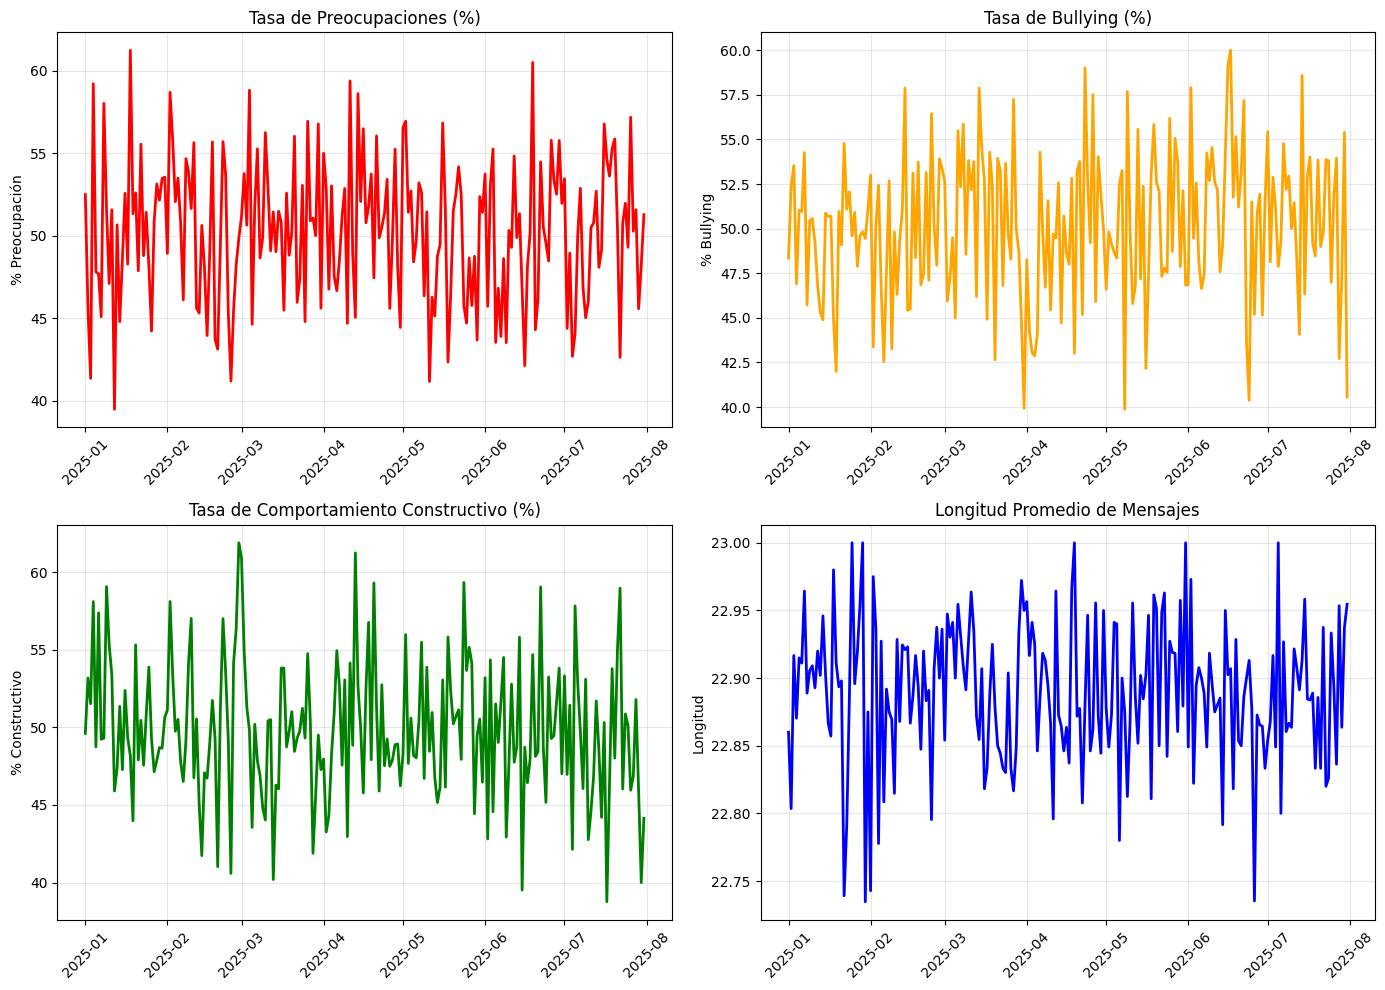

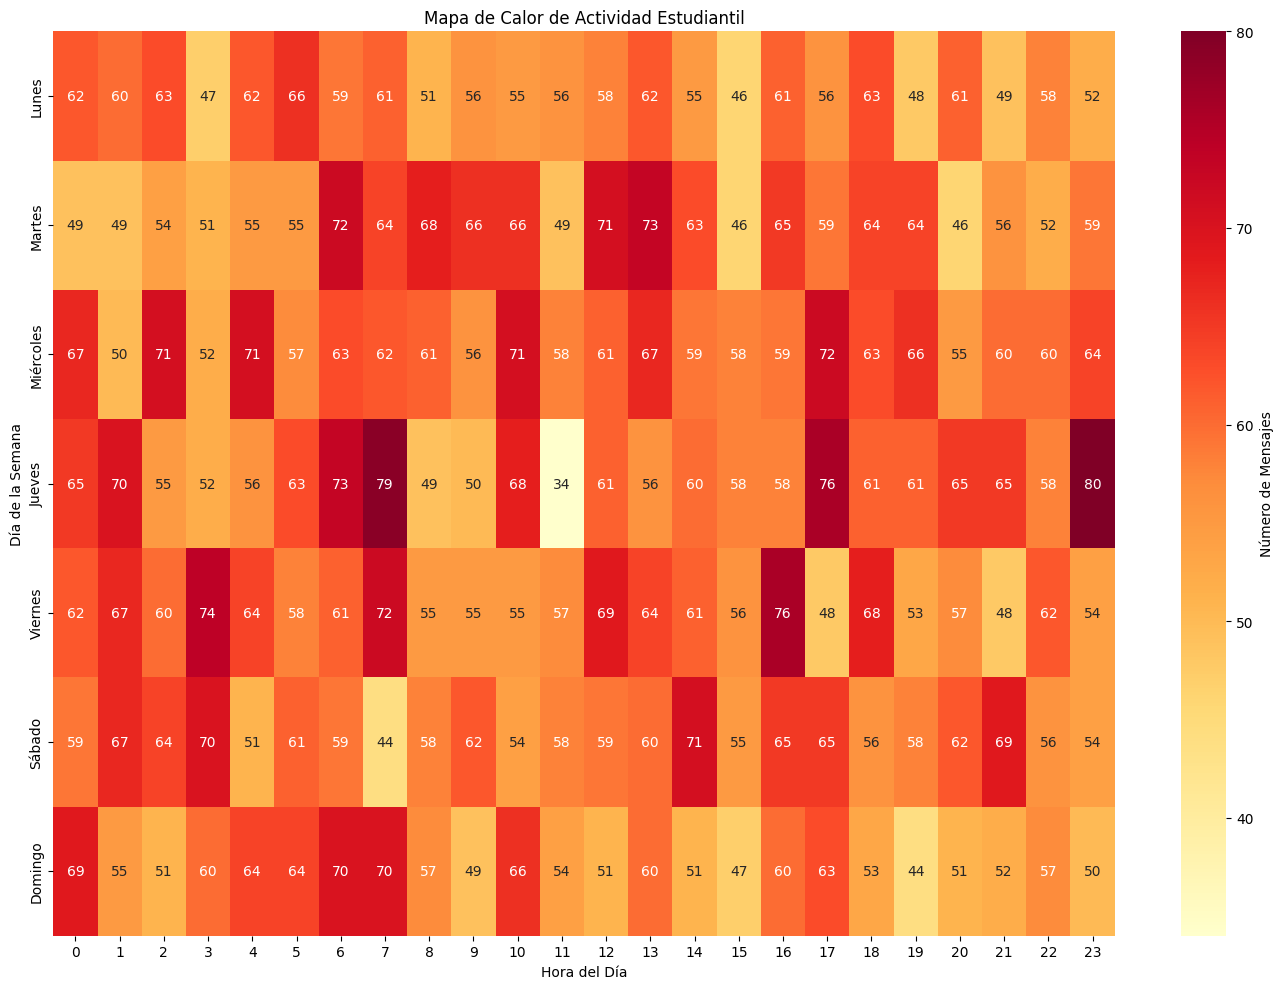

In [23]:
edu_viz = EducationalVisualizer(figsize=(14, 10))

# Tendencias de engagement (requiere: 'created_at', 'concern', 'bullying', 'academic_constructive', 'message_length')
edu_viz.plot_engagement_trends(ai_clean, date_column='created_at')

# Mapa de calor de actividad estudiantil por hora y día
edu_viz.plot_student_activity_heatmap(ai_clean)

,created_at,sender_id,recipient_id,message_content,analysis,message_length,bullying,concern,academic_constructive,hour,day_of_week,month,is_weekend
count,10000,10000,10000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000
unique,NaN,20,5,10000,10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,student_11,tutor_1,Mensaje de ejemplo 0,"{'bullying': 0.8408506850912019, 'concern': 0....",NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
freq,NaN,549,2029,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7195
mean,2025-04-16 09:06:54.255787520+00:00,NaN,NaN,NaN,NaN,22.889000,0.501792,0.502977,0.498869,11.402100,3.001800,3.998100,NaN
min,2025-01-01 00:38:43.478000+00:00,NaN,NaN,NaN,NaN,20.000000,0.000034,0.000306,0.000094,0.000000,0.000000,1.000000,NaN
25%,2025-02-22 10:22:23.053750016+00:00,NaN,NaN,NaN,NaN,23.000000,0.248715,0.252644,0.248614,5.000000,1.000000,2.000000,NaN
50%,2025-04-16 17:34:58.864000+00:00,NaN,NaN,NaN,NaN,23.000000,0.506471,0.501087,0.501717,11.000000,3.000000,4.000000,NaN
75%,2025-06-07 21:28:24.040499968+00:00,NaN,NaN,NaN,NaN,23.000000,0.753545,0.756551,0.748978,17.000000,5.000000,6.000000,NaN
max,2025-07-31 23:46:18.105000+00:00,NaN,NaN,NaN,NaN,23.000000,0.999879,0.999864,0.999878,23.000000,6.000000,7.000000,NaN


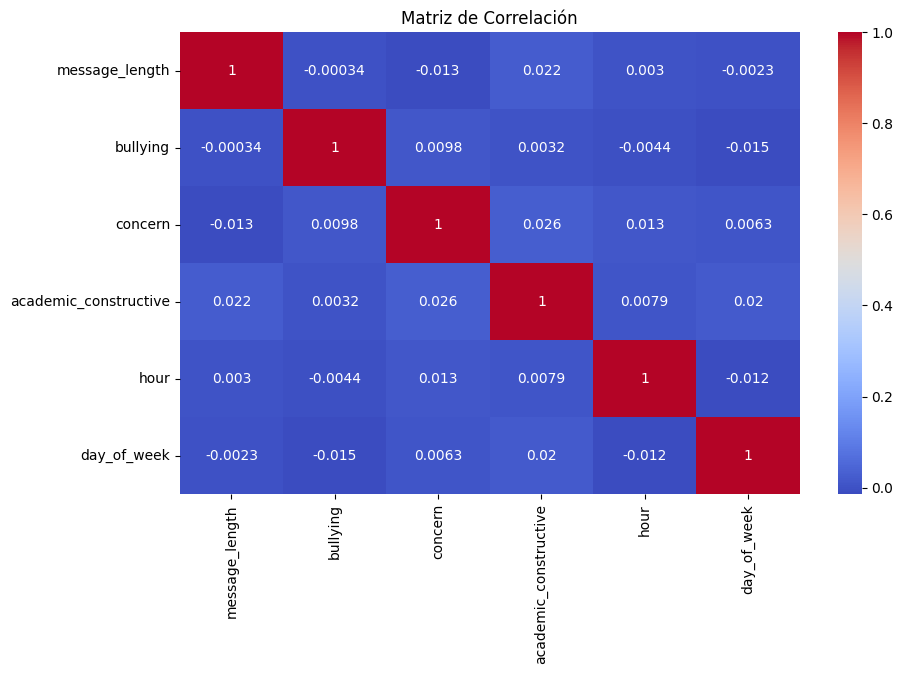

In [24]:
# Estadísticas descriptivas rápidas
display(ai_clean.describe(include='all'))
ai_clean_copy = ai_clean.drop(columns=['month']).copy()

# Matriz de correlación para variables numéricas
plt.figure(figsize=(10, 6))
sns.heatmap(ai_clean_copy.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación")
plt.show()

📊 Generando heatmap de correlaciones...


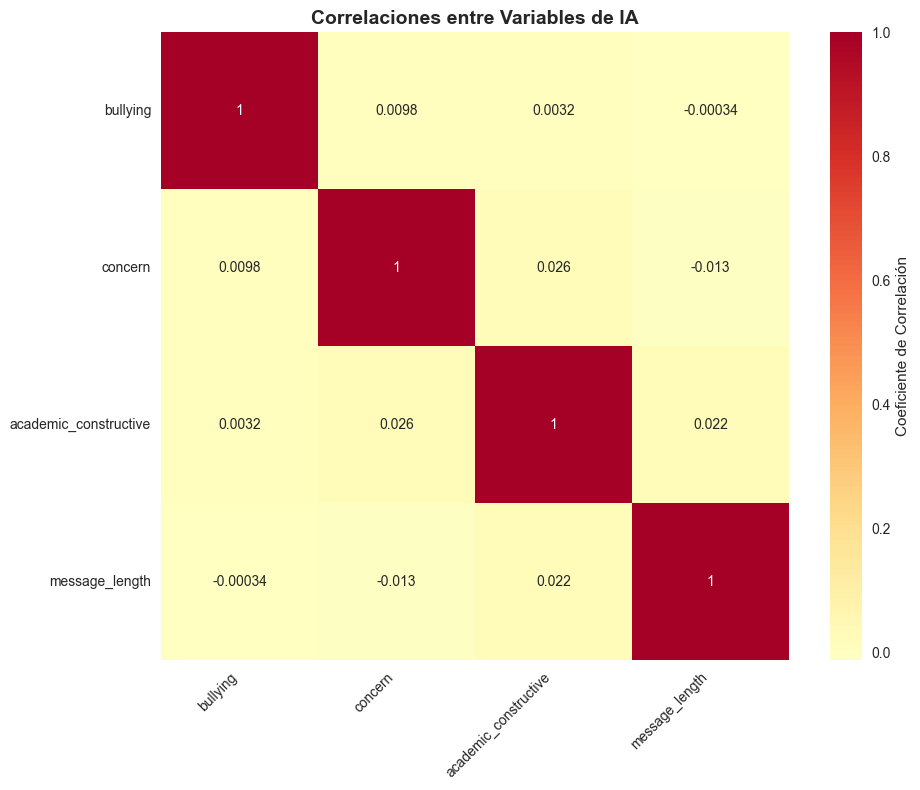

📈 Generando distribución de scores...


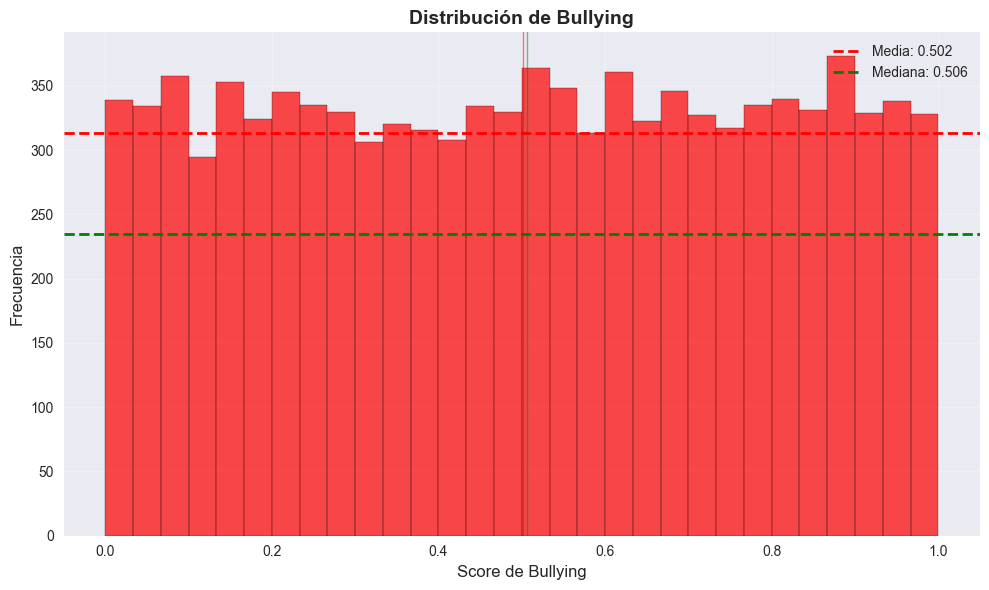

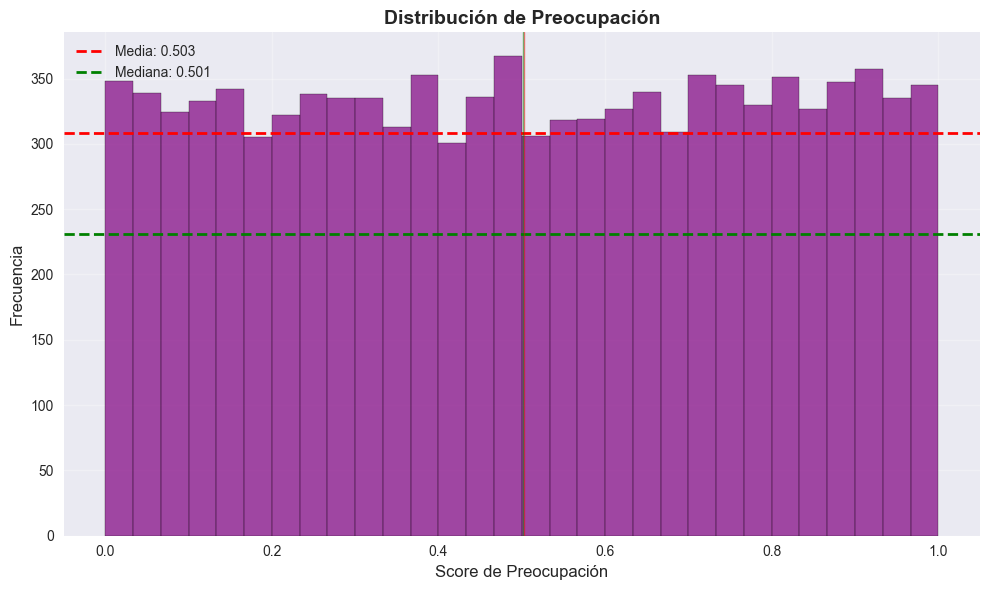

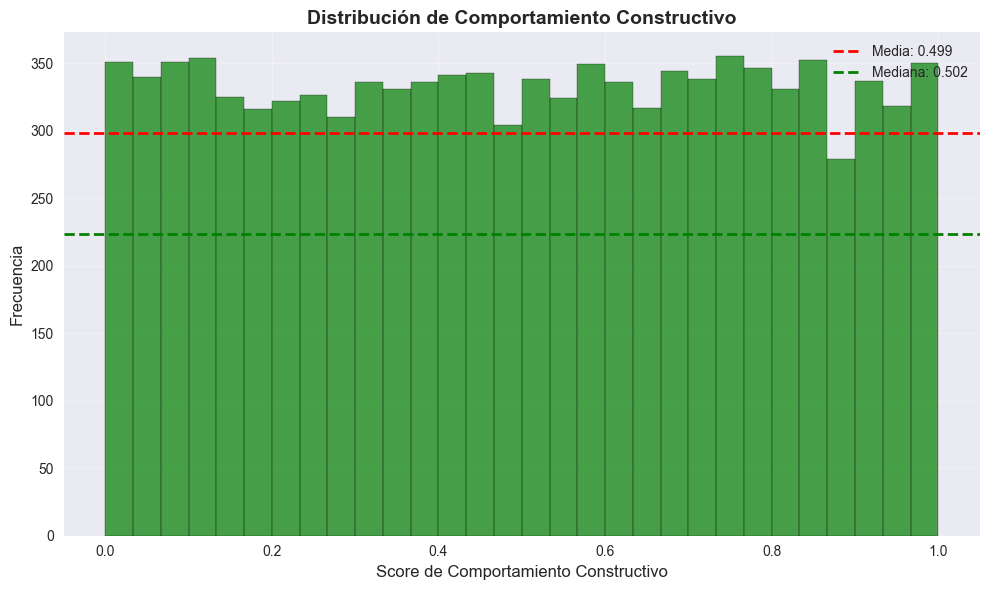

⏰ Generando análisis temporal...


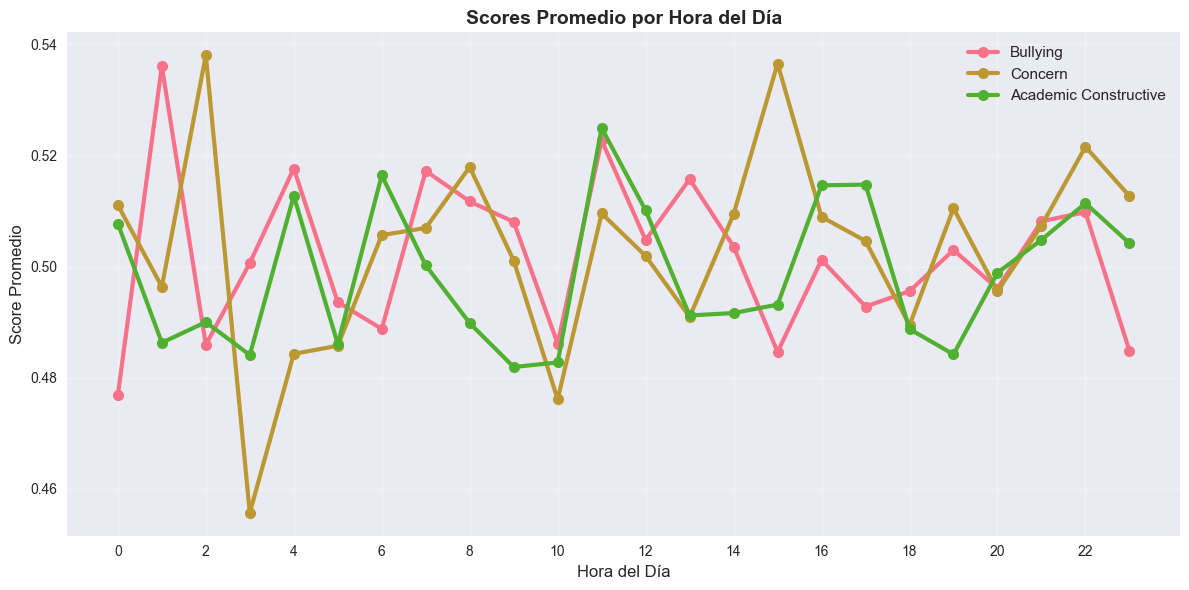

 Generando análisis por día de la semana...


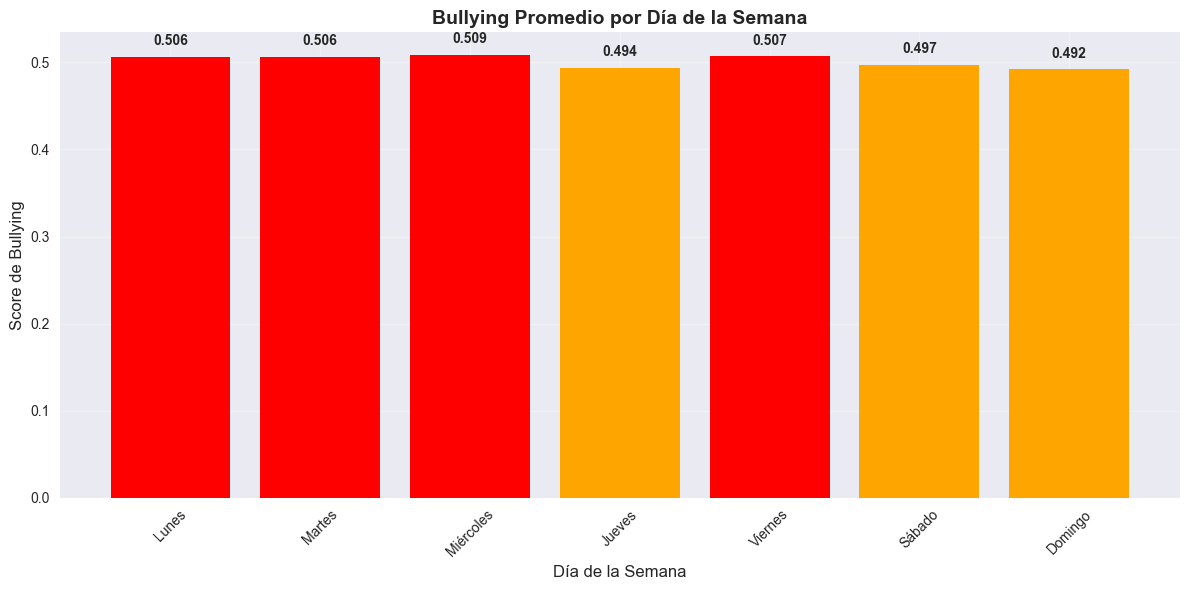

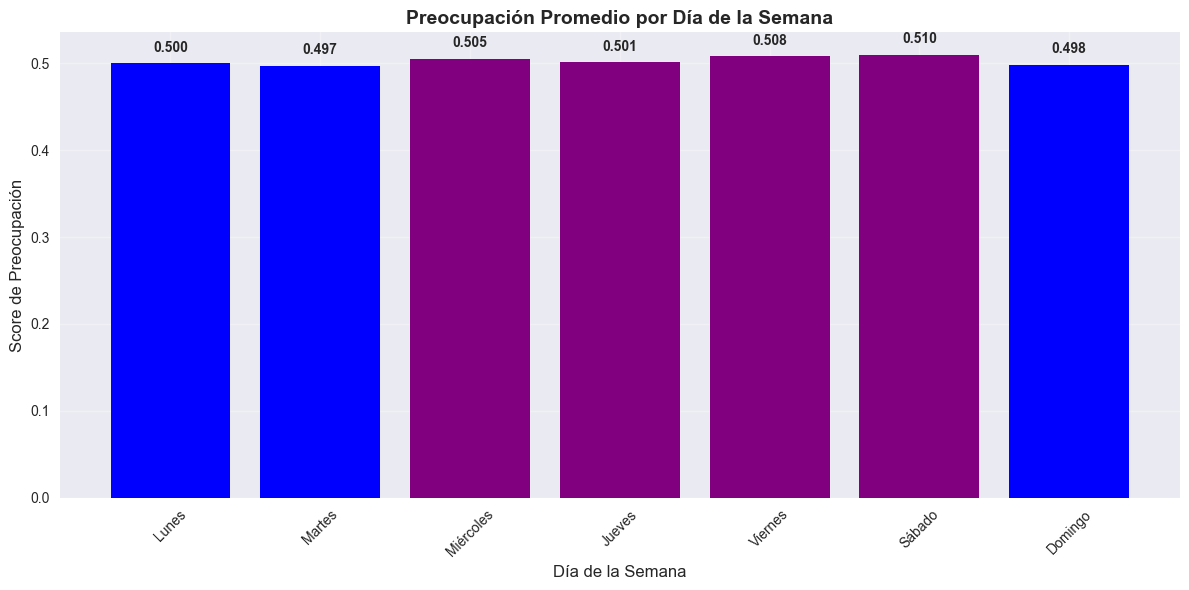

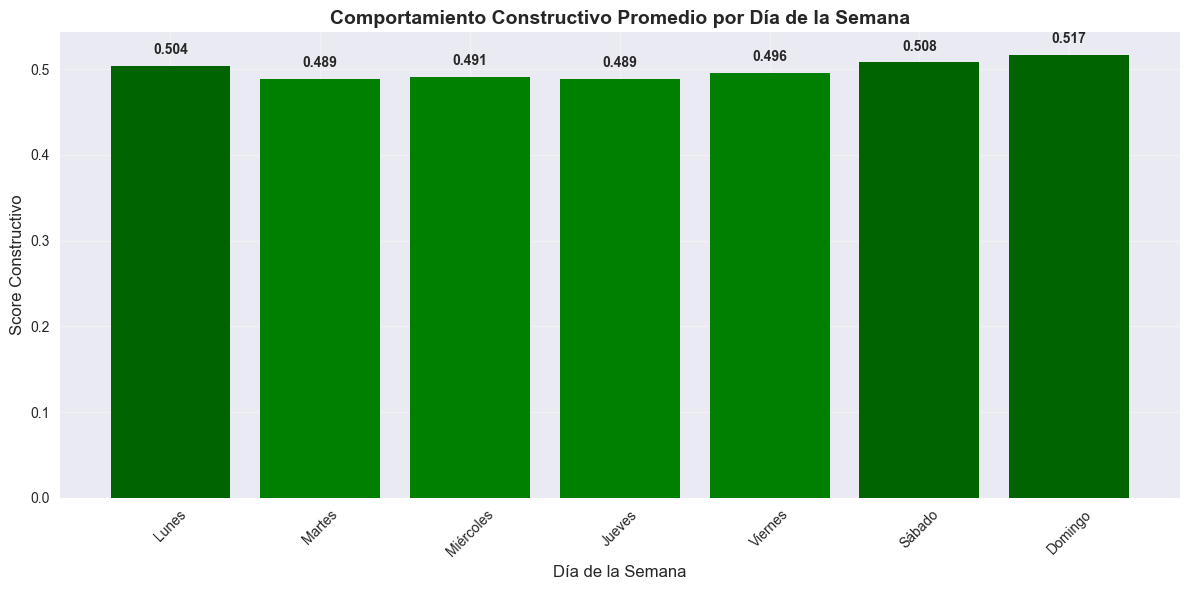

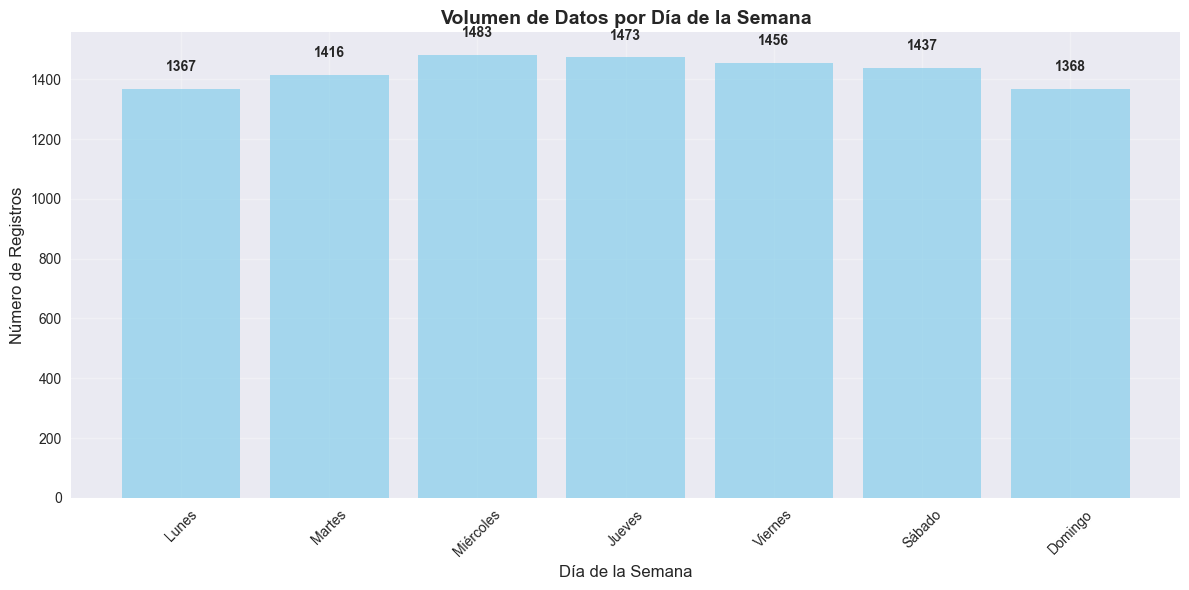


📋 RESUMEN ESTADÍSTICO DE RELACIONES:

🔗 CORRELACIONES PRINCIPALES:
   bullying vs concern: 0.010
   bullying vs academic_constructive: 0.003
   bullying vs message_length: -0.000
   concern vs academic_constructive: 0.026
   concern vs message_length: -0.013
   academic_constructive vs message_length: 0.022

⏰ HORAS DE MAYOR ACTIVIDAD:
   Bullying máximo: 1:00 hrs
   Preocupación máxima: 2:00 hrs
   Constructividad máxima: 11:00 hrs

 DÍA CON MAYOR BULLYING: Miércoles (0.509)
📅 DÍA CON MAYOR PREOCUPACIÓN: Sábado (0.510)
📅 DÍA MÁS CONSTRUCTIVO: Domingo (0.517)


In [25]:
# Configurar estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 1. HEATMAP DE CORRELACIONES
print("📊 Generando heatmap de correlaciones...")
correlation_cols = ['bullying', 'concern', 'academic_constructive', 'message_length']
correlation_matrix = ai_clean[correlation_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='RdYlBu_r', 
            center=0,
            square=True,
            cbar_kws={'label': 'Coeficiente de Correlación'})
plt.title('Correlaciones entre Variables de IA', fontweight='bold', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 2. DISTRIBUCIÓN DE SCORES - GRÁFICAS INDIVIDUALES
print("📈 Generando distribución de scores...")

# Distribución de Bullying
plt.figure(figsize=(10, 6))
plt.hist(ai_clean['bullying'], bins=30, alpha=0.7, color='red', edgecolor='black')
plt.title('Distribución de Bullying', fontweight='bold', fontsize=14)
plt.xlabel('Score de Bullying', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(True, alpha=0.3)

# Agregar líneas horizontales para umbrales (CORREGIDO)
mean_val = ai_clean['bullying'].mean()
median_val = ai_clean['bullying'].median()
plt.axhline(y=plt.gca().get_ylim()[1] * 0.8, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_val:.3f}')
plt.axhline(y=plt.gca().get_ylim()[1] * 0.6, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_val:.3f}')

# Agregar líneas verticales en los valores de media y mediana
plt.axvline(x=mean_val, color='red', linestyle='-', alpha=0.5, linewidth=1)
plt.axvline(x=median_val, color='green', linestyle='-', alpha=0.5, linewidth=1)

plt.legend()
plt.tight_layout()
plt.show()

# Distribución de Concern
plt.figure(figsize=(10, 6))
plt.hist(ai_clean['concern'], bins=30, alpha=0.7, color='purple', edgecolor='black')
plt.title('Distribución de Preocupación', fontweight='bold', fontsize=14)
plt.xlabel('Score de Preocupación', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(True, alpha=0.3)

# Agregar líneas horizontales para umbrales (CORREGIDO)
mean_val = ai_clean['concern'].mean()
median_val = ai_clean['concern'].median()
plt.axhline(y=plt.gca().get_ylim()[1] * 0.8, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_val:.3f}')
plt.axhline(y=plt.gca().get_ylim()[1] * 0.6, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_val:.3f}')

# Agregar líneas verticales en los valores de media y mediana
plt.axvline(x=mean_val, color='red', linestyle='-', alpha=0.5, linewidth=1)
plt.axvline(x=median_val, color='green', linestyle='-', alpha=0.5, linewidth=1)

plt.legend()
plt.tight_layout()
plt.show()

# Distribución de Academic Constructive
plt.figure(figsize=(10, 6))
plt.hist(ai_clean['academic_constructive'], bins=30, alpha=0.7, color='green', edgecolor='black')
plt.title('Distribución de Comportamiento Constructivo', fontweight='bold', fontsize=14)
plt.xlabel('Score de Comportamiento Constructivo', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(True, alpha=0.3)

mean_val = ai_clean['academic_constructive'].mean()
median_val = ai_clean['academic_constructive'].median()
plt.axhline(y=plt.gca().get_ylim()[1] * 0.8, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_val:.3f}')
plt.axhline(y=plt.gca().get_ylim()[1] * 0.6, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_val:.3f}')

plt.legend()
plt.tight_layout()
plt.show()

# 3. ANÁLISIS TEMPORAL - SCORES POR HORA DEL DÍA
print("⏰ Generando análisis temporal...")
hourly_scores = ai_clean.groupby('hour')[['bullying', 'concern', 'academic_constructive']].mean()

plt.figure(figsize=(12, 6))
for col in ['bullying', 'concern', 'academic_constructive']:
    plt.plot(hourly_scores.index, hourly_scores[col], 
             marker='o', linewidth=3, markersize=8, label=col.replace('_', ' ').title())

plt.title('Scores Promedio por Hora del Día', fontweight='bold', fontsize=14)
plt.xlabel('Hora del Día', fontsize=12)
plt.ylabel('Score Promedio', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 2))
plt.tight_layout()
plt.show()

# 4. ANÁLISIS POR DÍA DE LA SEMANA - GRÁFICAS INDIVIDUALES
print(" Generando análisis por día de la semana...")
# Mapear números a nombres de días
day_names = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
ai_clean['day_name'] = ai_clean['day_of_week'].map(lambda x: day_names[x] if x < 7 else 'Desconocido')

# Calcular estadísticas por día
daily_stats = ai_clean.groupby('day_name').agg({
    'bullying': ['mean', 'std', 'count'],
    'concern': ['mean', 'std'],
    'academic_constructive': ['mean', 'std']
}).round(3)

# Flatten column names
daily_stats.columns = ['_'.join(col).strip() for col in daily_stats.columns]

# Ordenar por días de la semana (Lunes a Domingo)
day_order = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
daily_stats = daily_stats.reindex(day_order)

# 1. Bullying por día
plt.figure(figsize=(12, 6))
bars1 = plt.bar(range(len(daily_stats)), daily_stats['bullying_mean'].values, 
                color=['red' if x > 0.5 else 'orange' if x > 0.3 else 'green' for x in daily_stats['bullying_mean'].values])
plt.title('Bullying Promedio por Día de la Semana', fontweight='bold', fontsize=14)
plt.ylabel('Score de Bullying', fontsize=12)
plt.xlabel('Día de la Semana', fontsize=12)
plt.xticks(range(len(daily_stats)), daily_stats.index, rotation=45)
plt.grid(True, alpha=0.3)

# Agregar valores en las barras
for bar, value in zip(bars1, daily_stats['bullying_mean'].values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 2. Concern por día
plt.figure(figsize=(12, 6))
bars2 = plt.bar(range(len(daily_stats)), daily_stats['concern_mean'].values,
                color=['purple' if x > 0.5 else 'blue' if x > 0.3 else 'lightblue' for x in daily_stats['concern_mean'].values])
plt.title('Preocupación Promedio por Día de la Semana', fontweight='bold', fontsize=14)
plt.ylabel('Score de Preocupación', fontsize=12)
plt.xlabel('Día de la Semana', fontsize=12)
plt.xticks(range(len(daily_stats)), daily_stats.index, rotation=45)
plt.grid(True, alpha=0.3)

for bar, value in zip(bars2, daily_stats['concern_mean'].values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 3. Academic Constructive por día
plt.figure(figsize=(12, 6))
bars3 = plt.bar(range(len(daily_stats)), daily_stats['academic_constructive_mean'].values,
                color=['darkgreen' if x > 0.5 else 'green' if x > 0.3 else 'lightgreen' for x in daily_stats['academic_constructive_mean'].values])
plt.title('Comportamiento Constructivo Promedio por Día de la Semana', fontweight='bold', fontsize=14)
plt.ylabel('Score Constructivo', fontsize=12)
plt.xlabel('Día de la Semana', fontsize=12)
plt.xticks(range(len(daily_stats)), daily_stats.index, rotation=45)
plt.grid(True, alpha=0.3)

for bar, value in zip(bars3, daily_stats['academic_constructive_mean'].values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 4. Volumen de datos por día
plt.figure(figsize=(12, 6))
bars4 = plt.bar(range(len(daily_stats)), daily_stats['bullying_count'].values,
                color='skyblue', alpha=0.7)
plt.title('Volumen de Datos por Día de la Semana', fontweight='bold', fontsize=14)
plt.ylabel('Número de Registros', fontsize=12)
plt.xlabel('Día de la Semana', fontsize=12)
plt.xticks(range(len(daily_stats)), daily_stats.index, rotation=45)
plt.grid(True, alpha=0.3)

for bar, value in zip(bars4, daily_stats['bullying_count'].values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{int(value)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# RESUMEN ESTADÍSTICO
print("\n📋 RESUMEN ESTADÍSTICO DE RELACIONES:")
print("=" * 50)

# Correlaciones más importantes
print("\n🔗 CORRELACIONES PRINCIPALES:")
for i in range(len(correlation_cols)):
    for j in range(i+1, len(correlation_cols)):
        col1, col2 = correlation_cols[i], correlation_cols[j]
        corr = correlation_matrix.loc[col1, col2]
        print(f"   {col1} vs {col2}: {corr:.3f}")

# Horas de mayor riesgo
print("\n⏰ HORAS DE MAYOR ACTIVIDAD:")
max_bullying_hour = hourly_scores['bullying'].idxmax()
max_concern_hour = hourly_scores['concern'].idxmax()
max_academic_hour = hourly_scores['academic_constructive'].idxmax()
print(f"   Bullying máximo: {max_bullying_hour}:00 hrs")
print(f"   Preocupación máxima: {max_concern_hour}:00 hrs")
print(f"   Constructividad máxima: {max_academic_hour}:00 hrs")

# Días de mayor actividad
print(f"\n DÍA CON MAYOR BULLYING: {daily_stats['bullying_mean'].idxmax()} ({daily_stats['bullying_mean'].max():.3f})")
print(f"📅 DÍA CON MAYOR PREOCUPACIÓN: {daily_stats['concern_mean'].idxmax()} ({daily_stats['concern_mean'].max():.3f})")
print(f"📅 DÍA MÁS CONSTRUCTIVO: {daily_stats['academic_constructive_mean'].idxmax()} ({daily_stats['academic_constructive_mean'].max():.3f})")

In [26]:
print(appointments_clean.columns)
print(appointments_clean['days_to_appointment'].head())
print(appointments_clean['days_to_appointment'].dropna().shape)

Index(['fecha_cita', 'id_tutor', 'id_alumno', 'estado_cita', 'reason',
       'checklist', 'created_at', 'updated_at', 'days_to_appointment'],
      dtype='object')
0    0
1    0
2    0
3    0
4    0
Name: days_to_appointment, dtype: int64
(10000,)


📊 Generando distribución de estados de citas...


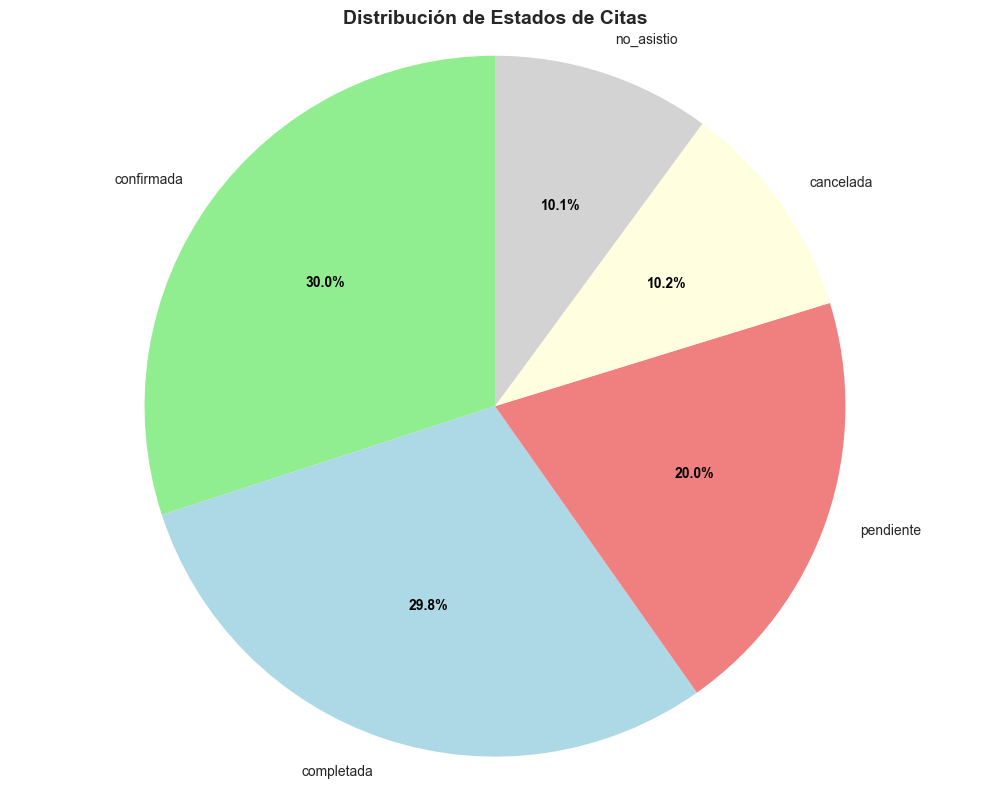

📅 Generando tasa de asistencia por día...


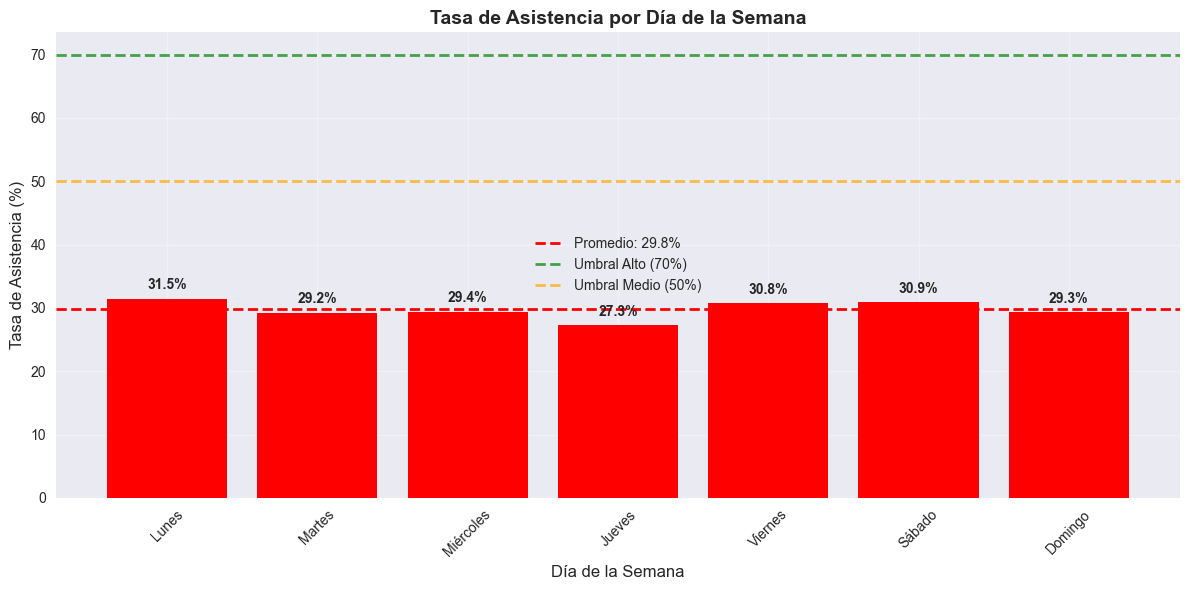

⏰ Generando tasa de asistencia por hora...


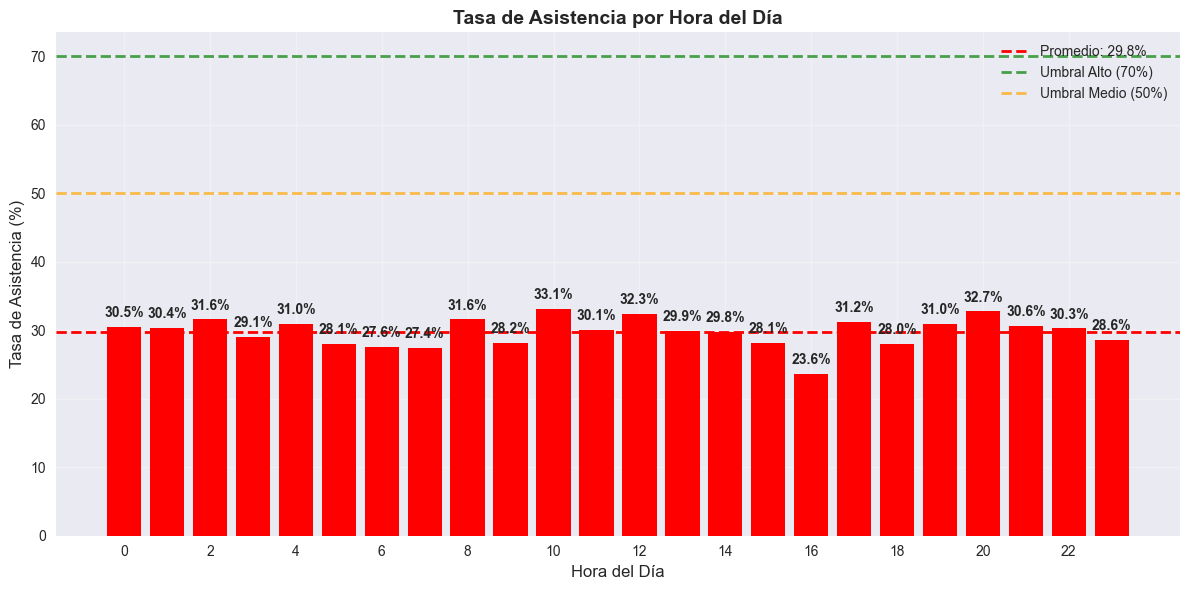


📋 RESUMEN DE ANÁLISIS DE CITAS:

📊 ESTADOS DE CITAS:
   confirmada: 3002 citas (30.0%)
   completada: 2975 citas (29.8%)
   pendiente: 1999 citas (20.0%)
   cancelada: 1016 citas (10.2%)
   no_asistio: 1008 citas (10.1%)

📅 DÍA CON MAYOR ASISTENCIA: Lunes (31.5%)
⏰ HORA CON MAYOR ASISTENCIA: 10:00 hrs (33.1%)
📊 Generando tasa de completado de tareas...


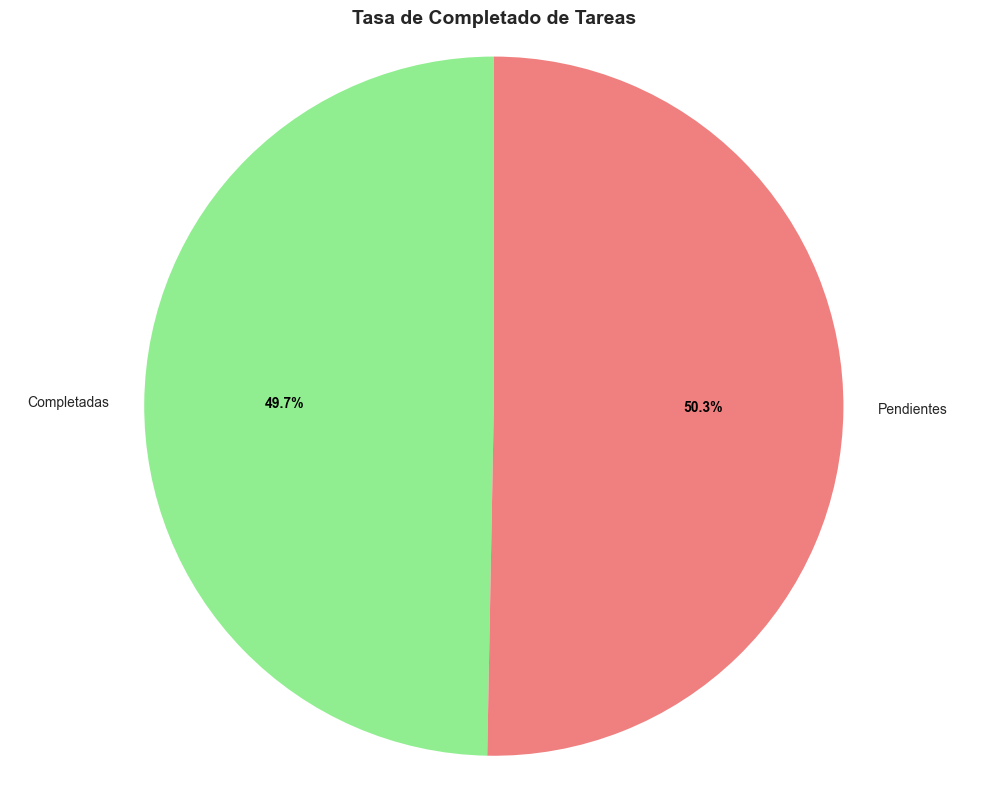

 Generando tasa de completado por día...


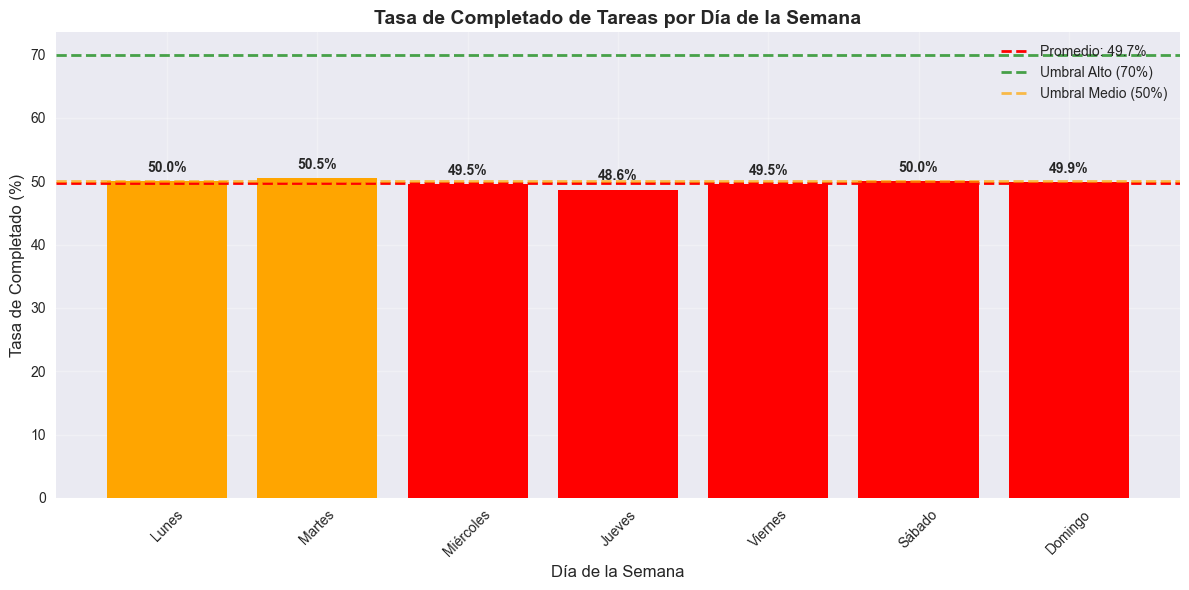

👨‍�� Generando análisis de productividad por tutor...


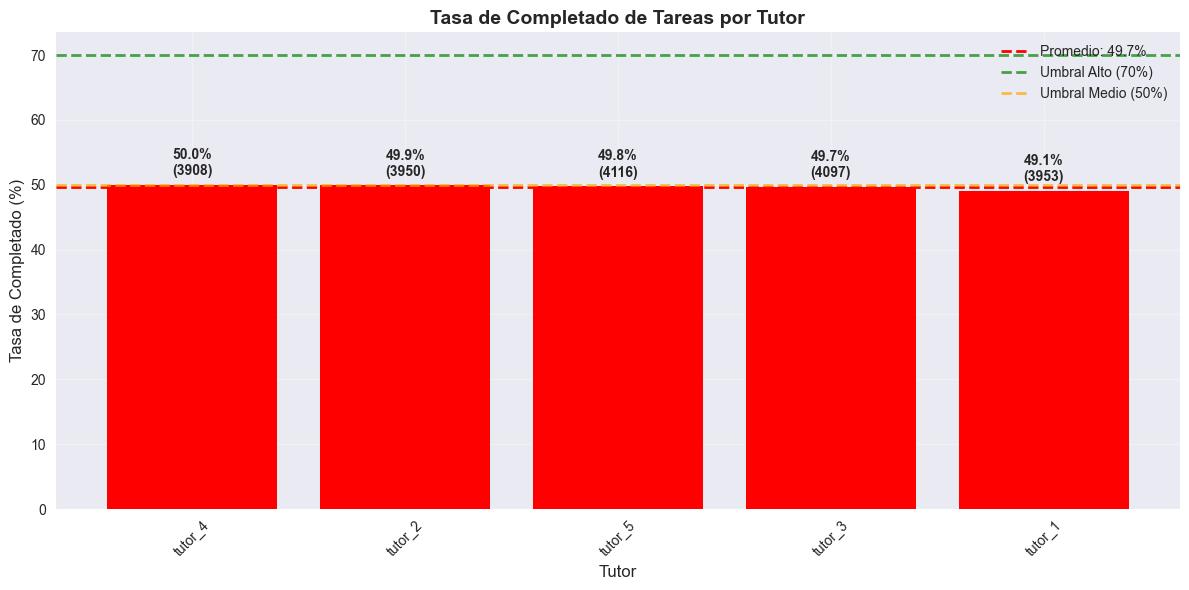


📋 RESUMEN DE ANÁLISIS DE TAREAS:

📊 ESTADO GENERAL DE TAREAS:
   Total de tareas: 20024
   Tareas completadas: 9952
   Tasa de completado: 49.7%

 DÍA CON MAYOR COMPLETADO: Martes (50.5%)


In [27]:
# Análisis de citas
edu_viz.plot_appointment_analysis(appointments_clean)

tasks_clean['fecha_cita'] = pd.to_datetime(tasks_clean['fecha_cita'])
# Análisis de tareas
edu_viz.plot_task_completion_analysis(tasks_clean)

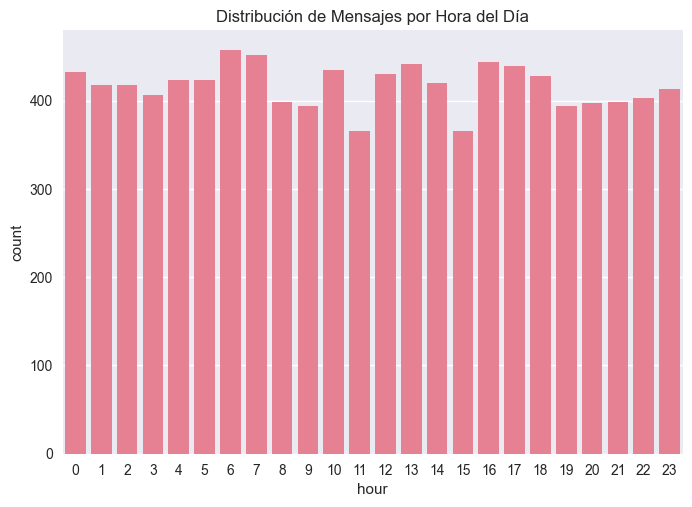

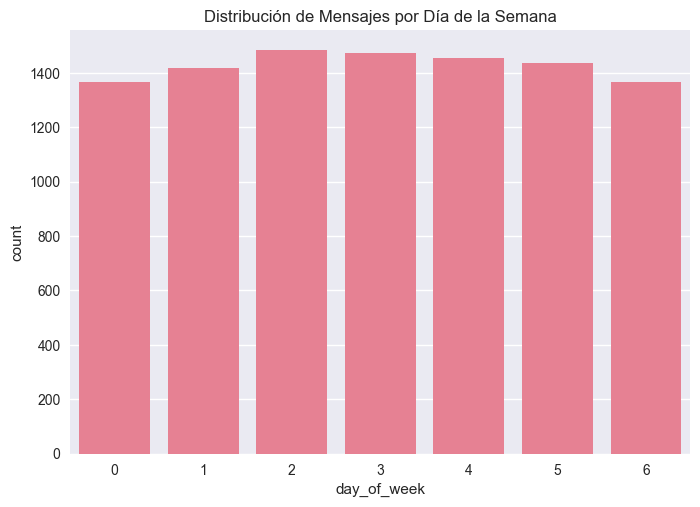

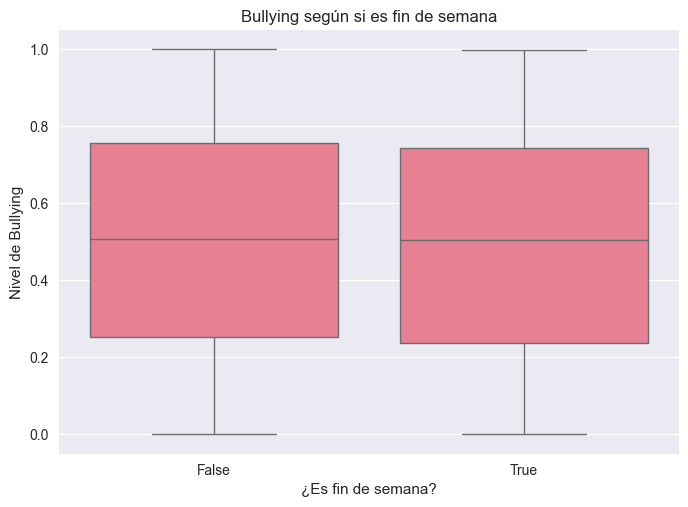

In [28]:
# Distribución de mensajes por hora del día
sns.countplot(data=ai_clean, x='hour')
plt.title("Distribución de Mensajes por Hora del Día")
plt.show()

# Distribución de mensajes por día de la semana
sns.countplot(data=ai_clean, x='day_of_week')
plt.title("Distribución de Mensajes por Día de la Semana")
plt.show()

# ¿Hay más bullying en fines de semana?
sns.boxplot(data=ai_clean, x='is_weekend', y='bullying')
plt.title("Bullying según si es fin de semana")
plt.xlabel("¿Es fin de semana?")
plt.ylabel("Nivel de Bullying")
plt.show()

In [29]:
import os

# Ruta base donde se encuentra ai_clean.csv
ruta_base = os.path.dirname('data')

# Guardar los DataFrames limpios
appointments_clean.to_csv(os.path.join(ruta_base, 'appointments_clean.csv'), index=False)
tasks_clean.to_csv(os.path.join(ruta_base, 'tasks_clean.csv'), index=False)
ai_clean.to_csv(os.path.join(ruta_base, 'ai_clean.csv'), index=False)

print("✅ Archivos guardados en la carpeta /data:")
print(" - appointments_clean.csv")
print(" - tasks_clean.csv")
print(" - ai_clean.csv")

✅ Archivos guardados en la carpeta /data:
 - appointments_clean.csv
 - tasks_clean.csv
 - ai_clean.csv
